<a href="https://colab.research.google.com/github/Erickm91/Projeto_Awari_Data_Science/blob/main/Projeto_Awari_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 # Projeto Data Science Awari - Erick Mendes


## Importando as bibliotecas utilizadas

In [ ]:
import pandas as pd
import numpy as np
from google.colab import auth
import missingno as msno
from sklearn.covariance import EllipticEnvelope
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
!pip install -q shap # Run this if you do not have shap installed
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 14.2 MB/s eta 0:00:00


## Funções utilizadas

In [ ]:
def calcula_metricas(y_true, y_pred_proba, y_pred_bin):
   
    print('')
    print('AUC: {:.2f}'.format(roc_auc_score(y_true, y_pred_proba)))
   
    
    a = pd.DataFrame({'y_true': y_true, 'y_predicted': y_pred_proba})
    rvs1 = a.loc[a.y_true==1, 'y_predicted']
    rvs2 = a.loc[a.y_true==0, 'y_predicted']
    print('Test KS: {}'.format(stats.ks_2samp(rvs1, rvs2)))
    print('')
        
        
        
    
    ## ROC Curve
    print('ROC Curve:')
    fpr, tpr, threshold = roc_curve(y_true, y_pred_proba)
    roc_auc_train = auc(fpr, tpr)    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_train)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for Train dataset')
    plt.legend(loc="lower right")
    plt.show()
    
    print(' Confusion Matrix: ')
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred_bin)
    plt.show()
    print('')

    print('------------------------------------')
    print(classification_report(y_true, y_pred_bin))
    print('------------------------------------')
    print('Probability Distribution:')
    max_x = np.max(y_pred_proba)
    bins = np.linspace(0, max_x, int(100*max_x))
    plt.hist(y_pred_proba,bins=bins,range=(0,max_x))
    plt.show()
    print('Probability Distribution between the classes:')
    df_hist = pd.DataFrame()
    df_hist['prob'] = np.array(y_pred_proba)
    df_hist['true'] = np.array(y_true)
    prob_true = df_hist.loc[df_hist['true']==1,'prob'].copy()
    prob_false = df_hist.loc[df_hist['true']==0,'prob'].copy()
    plt.hist(prob_true, bins, alpha=0.6, label='Positive Class',range=(0,max_x),density=True)
    plt.hist(prob_false, bins, alpha=0.6, label='Negative Class',range=(0,max_x),density=True)
    plt.legend(loc='upper right')
    plt.show()
    plt.hist(prob_true,bins,alpha=0.5,label='Positive Class Cumulative', cumulative=True,density=True)
    plt.hist(prob_false,bins,alpha=0.5,label='Negative Class Cumulative', cumulative=True,density=True)
    plt.legend(loc='upper right')
    plt.show()

## Se conectando ao BigQuery

In [ ]:
auth.authenticate_user()

In [ ]:
PROJECT_ID = 'dsproject-370022' # colocar aqui o id do seu projeto no Bigquery

## Query utilizada para extrair o dataset do projeto

In [ ]:
QUERY = f'''
WITH usuarios AS (
                SELECT
                    id as user_id,
                    operating_system,
                    salary,
                    credit_score,
                    date_birth,
                    DATE_DIFF(DATE(DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY)), DATE(date_birth), YEAR) as age
                FROM
                `dsproject-370022.app_data.users_profile`
), eventos AS (
                SELECT
                    user_id,
                    SUM(CASE WHEN event_name = 'app.home_view' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_home_view_last_7_days,
                    SUM(CASE WHEN event_name = 'app.home_view' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_home_view_last_15_days,
                    SUM(CASE WHEN event_name = 'app.search' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_searches_last_7_days,
                    SUM(CASE WHEN event_name = 'app.search' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_searches_last_15_days,
                    SUM(CASE WHEN event_name = 'app.search' AND section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_restaurant_searches_last_7_days,
                    SUM(CASE WHEN event_name = 'app.search' AND section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_restaurant_searches_last_15_days,
                    SUM(CASE WHEN event_name = 'app.search' AND section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_supermarket_searches_last_7_days,
                    SUM(CASE WHEN event_name = 'app.search' AND section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_supermarket_searches_last_15_days,
                    SUM(CASE WHEN event_name = 'app.added_to_cart' AND section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) AS sum_total_value_restaurant_add_cart_last_7_days,   
                    SUM(CASE WHEN event_name = 'app.added_to_cart' AND section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) AS sum_total_value_restaurant_add_cart_last_15_days,
                    SUM(CASE WHEN event_name = 'app.added_to_cart' AND section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) AS sum_total_value_supermarket_add_cart_last_7_days,   
                    SUM(CASE WHEN event_name = 'app.added_to_cart' AND section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) AS sum_total_value_supermarket_add_cart_last_15_days    
                FROM
                `dsproject-370022.app_data.events`
                WHERE DATE(date) <= DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) -- selecionando apenas eventos anteriores a data de corte, 7 dia antes da ultima data disponivel na base de dados
                GROUP BY user_id
), pedidos_anteriores AS (
                        SELECT 
                            user_id,
                            SUM(total_value) as sum_total_value_orders,
                            AVG(total_value) as avg_total_value_orders,
                            SUM(CASE WHEN section = 'restaurant' THEN total_value END ) AS sum_total_value_restaurant_orders,
                            SUM(CASE WHEN section = 'supermarket' THEN total_value END ) AS sum_total_value_supermarket_orders,  
                            AVG(CASE WHEN section = 'restaurant' THEN total_value END ) AS avg_total_value_restaurant_orders,
                            AVG(CASE WHEN section = 'supermarket' THEN total_value END ) AS avg_total_value_supermarket_orders,  
                            SUM(CASE WHEN DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as sum_total_value_orders_last_7_days,
                            SUM(CASE WHEN DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as sum_total_value_orders_last_15_days,
                            AVG(CASE WHEN DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as avg_total_value_orders_last_7_days,
                            AVG(CASE WHEN DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as avg_total_value_orders_last_15_days,
                            SUM(CASE WHEN section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as sum_total_value_restaurant_orders_last_7_days,
                            SUM(CASE WHEN section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as sum_total_value_restaurant_orders_last_15_days,
                            SUM(CASE WHEN section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as sum_total_value_supermarket_orders_last_7_days,
                            SUM(CASE WHEN section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as sum_total_value_supermarket_orders_last_15_days,
                            COUNT(*) as qtd_orders,
                            SUM(CASE WHEN DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) as qtd_orders_last_7_days,
                            SUM(CASE WHEN DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) as qtd_orders_last_15_days,
                            SUM(CASE WHEN section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) as qtd_restaurant_orders_last_7_days,
                            SUM(CASE WHEN section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) as qtd_restaurant_orders_last_15_days,
                            SUM(CASE WHEN section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) as qtd_supermarket_orders_last_7_days,
                            SUM(CASE WHEN section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) as qtd_supermarket_orders_last_15_days,
                            SUM(CASE WHEN payment_method = 'credit_card' THEN 1 ELSE 0 END) / COALESCE(COUNT(*), 1) AS taxa_credit_card_payments
                        FROM
                            `dsproject-370022.app_data.orders`
                        WHERE DATE(date) <= DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) -- selecionando apenas pedidos anteriores a data de corte, 7 dia antes da ultima data disponivel na base de dados
                        GROUP BY user_id

), target AS (
            SELECT 
                user_id,
                MAX(CASE WHEN DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) AND DATE('2021-05-31') THEN 1 ELSE 0 END) AS target
            FROM
            `dsproject-370022.app_data.orders`
            GROUP BY user_id
)
SELECT 
    usuarios.user_id,
    usuarios.operating_system,
    usuarios.salary,
    usuarios.credit_score,
    usuarios.age,
    eventos.qtd_home_view_last_7_days,
    eventos.qtd_home_view_last_15_days,
    eventos.qtd_searches_last_7_days,
    eventos.qtd_searches_last_15_days,
    eventos.qtd_restaurant_searches_last_7_days,
    eventos.qtd_restaurant_searches_last_15_days,
    eventos.qtd_supermarket_searches_last_7_days,
    eventos.qtd_supermarket_searches_last_15_days,
    eventos.sum_total_value_restaurant_add_cart_last_7_days,   
    eventos.sum_total_value_restaurant_add_cart_last_15_days,
    eventos.sum_total_value_supermarket_add_cart_last_7_days,   
    eventos.sum_total_value_supermarket_add_cart_last_15_days,    
    pedidos_anteriores.sum_total_value_orders,
    pedidos_anteriores.avg_total_value_orders,
    pedidos_anteriores.sum_total_value_restaurant_orders,
    pedidos_anteriores.sum_total_value_supermarket_orders,  
    pedidos_anteriores.avg_total_value_restaurant_orders,
    pedidos_anteriores.avg_total_value_supermarket_orders,  
    pedidos_anteriores.sum_total_value_orders_last_7_days,
    pedidos_anteriores.sum_total_value_orders_last_15_days,
    pedidos_anteriores.avg_total_value_orders_last_7_days,
    pedidos_anteriores.avg_total_value_orders_last_15_days,
    pedidos_anteriores.sum_total_value_restaurant_orders_last_7_days,
    pedidos_anteriores.sum_total_value_restaurant_orders_last_15_days,
    pedidos_anteriores.sum_total_value_supermarket_orders_last_7_days,
    pedidos_anteriores.sum_total_value_supermarket_orders_last_15_days,
    pedidos_anteriores.qtd_orders_last_7_days,
    pedidos_anteriores.qtd_orders_last_15_days,
    pedidos_anteriores.qtd_restaurant_orders_last_7_days,
    pedidos_anteriores.qtd_restaurant_orders_last_15_days,
    pedidos_anteriores.qtd_supermarket_orders_last_7_days,
    pedidos_anteriores.qtd_supermarket_orders_last_15_days,
    pedidos_anteriores.taxa_credit_card_payments,
    target.target
FROM 
usuarios
LEFT JOIN
eventos
ON usuarios.user_id = eventos.user_id
LEFT JOIN
pedidos_anteriores
ON usuarios.user_id = pedidos_anteriores.user_id
LEFT JOIN 
target
ON usuarios.user_id = target.user_id 
'''

In [ ]:
df = pd.io.gbq.read_gbq(QUERY, project_id=PROJECT_ID)

## Conferindo o dataset final

In [ ]:
pd.options.display.max_columns = None
df.head()

,user_id,operating_system,salary,credit_score,age,qtd_home_view_last_7_days,qtd_home_view_last_15_days,qtd_searches_last_7_days,qtd_searches_last_15_days,qtd_restaurant_searches_last_7_days,qtd_restaurant_searches_last_15_days,qtd_supermarket_searches_last_7_days,qtd_supermarket_searches_last_15_days,sum_total_value_restaurant_add_cart_last_7_days,sum_total_value_restaurant_add_cart_last_15_days,sum_total_value_supermarket_add_cart_last_7_days,sum_total_value_supermarket_add_cart_last_15_days,sum_total_value_orders,avg_total_value_orders,sum_total_value_restaurant_orders,sum_total_value_supermarket_orders,avg_total_value_restaurant_orders,avg_total_value_supermarket_orders,sum_total_value_orders_last_7_days,sum_total_value_orders_last_15_days,avg_total_value_orders_last_7_days,avg_total_value_orders_last_15_days,sum_total_value_restaurant_orders_last_7_days,sum_total_value_restaurant_orders_last_15_days,sum_total_value_supermarket_orders_last_7_days,sum_total_value_supermarket_orders_last_15_days,qtd_orders_last_7_days,qtd_orders_last_15_days,qtd_restaurant_orders_last_7_days,qtd_restaurant_orders_last_15_days,qtd_supermarket_orders_last_7_days,qtd_supermarket_orders_last_15_days,taxa_credit_card_payments,target
0,8792,android,4682.76,781,47,4,12,8,15,2,3,1,4,84.01,366.20,11.00,208.17,2893.98,55.653462,533.99,284.00,16.181515,56.800000,1067.01,1971.89,20.519423,37.920962,84.01,366.20,11.00,208.17,15,38,10,26,2,4,0.769231,1
1,15536,ios,2675.78,551,47,5,12,23,45,7,18,9,15,212.00,406.34,901.00,969.58,1363.54,29.011489,504.90,750.64,22.950000,35.744762,752.96,1014.13,16.020426,21.577234,182.32,341.68,570.64,639.22,13,27,8,15,5,11,0.851064,1
2,16944,ios,3278.60,814,47,6,14,19,45,7,16,8,22,619.99,880.73,1530.01,1742.91,2754.75,45.159836,946.98,1799.77,31.566000,64.277500,1759.35,2192.71,28.841803,35.946066,505.18,733.32,1248.17,1451.39,17,39,8,19,8,17,0.786885,1
3,19636,ios,5209.68,606,47,0,0,12,16,10,14,0,0,986.00,2134.63,0.00,28.00,3008.99,158.367895,2980.99,28.00,165.610556,28.000000,986.00,2162.63,51.894737,113.822632,986.00,2134.63,0.00,28.00,9,16,9,15,0,1,0.736842,1
4,19294,ios,126.51,642,47,7,16,10,17,5,10,3,3,558.99,889.67,1240.00,2335.11,4149.73,125.749394,1130.17,3019.56,45.206800,377.445000,1798.99,2700.58,54.514848,81.835758,558.99,844.58,1240.00,1856.00,13,22,10,18,3,4,0.818182,1


# Valindando o dataset de modelagem

### Calculando a quantidade de linhas e colunas

In [ ]:
df.shape

(20000, 39)

#Verificando se a quantidade de linhas confere com a quantidade de usuários distintos

A ideia aqui é verificar se nosso dataset está a nível de usuário, ou seja, queremos validar se não existe duplicidade, o esperado é somente uma linha por usuário

In [ ]:
df.user_id.nunique()

20000

In [ ]:
df.shape[0] == df.user_id.nunique()

True

##Verificando o tipo de cada uma das colunas

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 39 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   user_id                                            20000 non-null  Int64  
 1   operating_system                                   20000 non-null  object 
 2   salary                                             20000 non-null  float64
 3   credit_score                                       20000 non-null  Int64  
 4   age                                                20000 non-null  Int64  
 5   qtd_home_view_last_7_days                          19668 non-null  Int64  
 6   qtd_home_view_last_15_days                         19668 non-null  Int64  
 7   qtd_searches_last_7_days                           19668 non-null  Int64  
 8   qtd_searches_last_15_days                          19668 non-null  Int64  
 9   qtd_re

##Verificando as colunas com valores nulos

In [ ]:
print(df.isna().sum())

user_id                                                  0
operating_system                                         0
salary                                                   0
credit_score                                             0
age                                                      0
qtd_home_view_last_7_days                              332
qtd_home_view_last_15_days                             332
qtd_searches_last_7_days                               332
qtd_searches_last_15_days                              332
qtd_restaurant_searches_last_7_days                    332
qtd_restaurant_searches_last_15_days                   332
qtd_supermarket_searches_last_7_days                   332
qtd_supermarket_searches_last_15_days                  332
sum_total_value_restaurant_add_cart_last_7_days        332
sum_total_value_restaurant_add_cart_last_15_days       332
sum_total_value_supermarket_add_cart_last_7_days       332
sum_total_value_supermarket_add_cart_last_15_days      3

## Preenchendo os nulos

Todas as variáveis nulas que temos na base podem ser preenchidas com o valor 0 (zero), pois o fato de estarem nulas indicam a ausência de uma ação do usuário, ou seja, não realizou nenhum pedido, não acessou o aplicativo, não adicinou nada ao carrinho e assim por diante. A única variável que não segue a regra anterior é a **taxa_credit_card_payments**, pois ela indica um percentual de utilização de cartões de crédito, nesse sentido, uma forma adequada para preenche-la seria com a média

In [ ]:
## Primeiro resolvendos os nulos da coluna taxa_card_payments
df['taxa_credit_card_payments'].fillna(df['taxa_credit_card_payments'].dropna().mean(), inplace=True)

In [ ]:
## Em seguida resolvendo todos os outros valores nulos
df.fillna(0, inplace=True)

In [ ]:
## Resolvido os valores nulos
print(df.isna().sum())

user_id                                              0
operating_system                                     0
salary                                               0
credit_score                                         0
age                                                  0
qtd_home_view_last_7_days                            0
qtd_home_view_last_15_days                           0
qtd_searches_last_7_days                             0
qtd_searches_last_15_days                            0
qtd_restaurant_searches_last_7_days                  0
qtd_restaurant_searches_last_15_days                 0
qtd_supermarket_searches_last_7_days                 0
qtd_supermarket_searches_last_15_days                0
sum_total_value_restaurant_add_cart_last_7_days      0
sum_total_value_restaurant_add_cart_last_15_days     0
sum_total_value_supermarket_add_cart_last_7_days     0
sum_total_value_supermarket_add_cart_last_15_days    0
sum_total_value_orders                               0
avg_total_

## Tratamento das variaveis categóricas

Temos somente uma variável categórica em nossa base: operating_system. Uma das formas de transformar esse tipo de variavel é utilizando um método do próprio pandas **get_dummies()**

In [ ]:
df = pd.get_dummies(df)

In [ ]:
df.iloc[:,-2:].head()
## Para cada um das categorias da coluna operating_system, agora temos uma coluna correspondente, preenchidas com 0 e 1

,operating_system_android,operating_system_ios
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1


# Estatística do dados

## Análise descritiva

In [ ]:
df.describe().round(2)

,user_id,salary,credit_score,age,qtd_home_view_last_7_days,qtd_home_view_last_15_days,qtd_searches_last_7_days,qtd_searches_last_15_days,qtd_restaurant_searches_last_7_days,qtd_restaurant_searches_last_15_days,qtd_supermarket_searches_last_7_days,qtd_supermarket_searches_last_15_days,sum_total_value_restaurant_add_cart_last_7_days,sum_total_value_restaurant_add_cart_last_15_days,sum_total_value_supermarket_add_cart_last_7_days,sum_total_value_supermarket_add_cart_last_15_days,sum_total_value_orders,avg_total_value_orders,sum_total_value_restaurant_orders,sum_total_value_supermarket_orders,avg_total_value_restaurant_orders,avg_total_value_supermarket_orders,sum_total_value_orders_last_7_days,sum_total_value_orders_last_15_days,avg_total_value_orders_last_7_days,avg_total_value_orders_last_15_days,sum_total_value_restaurant_orders_last_7_days,sum_total_value_restaurant_orders_last_15_days,sum_total_value_supermarket_orders_last_7_days,sum_total_value_supermarket_orders_last_15_days,qtd_orders_last_7_days,qtd_orders_last_15_days,qtd_restaurant_orders_last_7_days,qtd_restaurant_orders_last_15_days,qtd_supermarket_orders_last_7_days,qtd_supermarket_orders_last_15_days,taxa_credit_card_payments,target,operating_system_android,operating_system_ios
count,20000.00,20000.00,20000.00,20000.00,20000.0,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00
mean,10000.50,3686.97,614.45,39.74,2.1,4.13,5.94,11.45,3.25,6.23,1.36,2.63,157.47,309.86,194.24,389.75,855.28,125.90,342.87,448.93,66.88,113.24,301.73,601.62,43.87,88.79,121.68,240.00,158.04,317.33,2.12,4.18,1.12,2.20,0.64,1.25,0.72,0.77,0.70,0.30
std,5773.65,3703.61,71.92,17.23,2.7,5.17,4.93,9.19,3.54,6.54,2.27,4.24,351.77,673.29,493.87,924.15,1480.34,199.97,813.29,1118.24,150.51,253.95,568.68,1069.47,94.81,160.87,307.25,581.90,439.94,815.04,2.87,5.39,2.10,3.92,1.42,2.66,0.23,0.42,0.46,0.46
min,1.00,0.00,424.00,17.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,5000.75,1066.07,559.00,25.00,0.0,0.00,2.00,5.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,22.29,10.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.67,1.00,0.00,0.00
50%,10000.50,2608.06,601.00,38.00,1.0,2.00,5.00,9.00,2.00,4.00,0.00,0.00,0.00,9.80,0.00,0.00,296.00,68.40,0.00,0.00,0.00,0.00,72.00,192.00,14.29,42.00,0.00,0.00,0.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.72,1.00,1.00,0.00
75%,15000.25,5143.16,663.00,52.00,3.0,6.00,8.00,16.00,5.00,9.00,2.00,4.00,161.99,337.27,144.00,361.01,1020.47,160.69,327.55,378.00,77.13,135.83,349.07,702.02,52.81,110.98,102.00,222.17,61.40,238.50,3.00,6.00,1.00,3.00,1.00,1.00,0.87,1.00,1.00,1.00
max,20000.00,35627.83,872.00,79.00,21.0,40.00,40.00,79.00,27.00,64.00,21.00,43.00,6545.00,13576.00,7172.00,15426.16,32187.72,5473.46,15714.00,22090.61,4368.00,5473.46,9549.71,22416.37,4368.00,5473.46,5602.07,13217.25,6023.00,13966.93,24.00,49.00,19.00,41.00,16.00,38.00,1.00,1.00,1.00,1.00


Algumas Descobertas após a analise descritiva:


*   O salario médio de nossos usuários é por volta de $ 3.7 mil
*   A idade média nos nossos usuários é 40 anos
*   Os usuários fazem em média 6 buscas por semana
*   Restaurante é a vertical mais buscada, com média de 3.2 buscas contra 1.3 buscas semanais em supermercados
*   Nossos usuários fazem em média 1.11 pedidos em restaurantes por semana contra 0.63 pedidos em supermercados


## Probabilidade de um usuário realizar pelo menos um pedido dentro de uma semana


Essa probabilidade pode ser calculada considerando o nosso **target** que representa exatamente os usuários que realizaram pelo menos uma compra dentro da ultima semana analisada em nossos dados. Assim, essa probabilidade pode ser calculada simplesmente considerando a média (ou taxa) do target

In [ ]:
df['target'].mean()

0.7693

Logo vemos que nossos usuários possuem uma probabilidade de 76% de realizar uma compra dentro de alguma semana

## Utilizando Percentis para analisar a quantidade de pedidos realizados

In [ ]:
df['qtd_orders_last_15_days'].describe(percentiles=[.25, .50, .75, .9]).round(2)

count    20000.00
mean         4.18
std          5.39
min          0.00
25%          0.00
50%          2.00
75%          6.00
90%         11.00
max         49.00
Name: qtd_orders_last_15_days, dtype: float64

Vemos que 50% dos usuários possuem até 2 pedidos considerando um periodo de 15 dias. Quando olhamos a média, temos 4.18 pedidos, ou seja, a média é muito afetada pelos usuários que fazem muitos pedidos. Assim a mediana (50%) representa melhor a quantidade de pedidos que a maioria dos usuários faz

## Verificando os outliers

Iremos utilizar a técnica "envelope elíptico" para identificação dos 
outliers no nosso dataset. Essa técnica parte da premissa que nossos dados possuem uma distribuição normal (gaussiana)

In [ ]:
elpenv = EllipticEnvelope(random_state=42, contamination=0.05)

# Returns 1 of inliers, -1 for outliers
df['outlier'] = elpenv.fit_predict(df[[col for col in df.columns if col not in ('user_id')]])

In [ ]:
df.outlier.value_counts(normalize=True)

 1    0.95
-1    0.05
Name: outlier, dtype: float64

In [ ]:
df_clean = df.loc[df.outlier == 1].drop('outlier', axis=1)

In [ ]:
df_clean.shape

(19000, 40)

In [ ]:
df_clean.target.mean().round(3)

0.758

Após a remoção dos outliers nosso dataset ficou com 19 mil linhas e manteve aproximadamente a mesma taxa do nosso target (~ 76%)

## Analisando a correlação entre as variáveis

In [ ]:
df_clean.corr()

,user_id,salary,credit_score,age,qtd_home_view_last_7_days,qtd_home_view_last_15_days,qtd_searches_last_7_days,qtd_searches_last_15_days,qtd_restaurant_searches_last_7_days,qtd_restaurant_searches_last_15_days,qtd_supermarket_searches_last_7_days,qtd_supermarket_searches_last_15_days,sum_total_value_restaurant_add_cart_last_7_days,sum_total_value_restaurant_add_cart_last_15_days,sum_total_value_supermarket_add_cart_last_7_days,sum_total_value_supermarket_add_cart_last_15_days,sum_total_value_orders,avg_total_value_orders,sum_total_value_restaurant_orders,sum_total_value_supermarket_orders,avg_total_value_restaurant_orders,avg_total_value_supermarket_orders,sum_total_value_orders_last_7_days,sum_total_value_orders_last_15_days,avg_total_value_orders_last_7_days,avg_total_value_orders_last_15_days,sum_total_value_restaurant_orders_last_7_days,sum_total_value_restaurant_orders_last_15_days,sum_total_value_supermarket_orders_last_7_days,sum_total_value_supermarket_orders_last_15_days,qtd_orders_last_7_days,qtd_orders_last_15_days,qtd_restaurant_orders_last_7_days,qtd_restaurant_orders_last_15_days,qtd_supermarket_orders_last_7_days,qtd_supermarket_orders_last_15_days,taxa_credit_card_payments,target,operating_system_android,operating_system_ios
user_id,1.000000,0.001131,0.001843,-0.000443,-0.072788,-0.099402,-0.001080,-0.002051,0.004744,0.000021,-0.010115,-0.007571,0.000421,0.000195,0.004231,-0.001914,-0.002261,-0.003493,-0.001218,-0.003611,-0.000592,-0.013249,0.007294,0.002082,0.006347,0.000954,0.001827,0.001797,0.007776,0.000452,0.007920,0.009024,0.006096,0.004606,-0.002000,-0.001202,0.019971,0.005420,0.001246,-0.001246
salary,0.001131,1.000000,0.345256,-0.000800,0.166927,0.160441,0.176274,0.179437,0.131831,0.133073,0.115945,0.118058,0.081501,0.084132,0.127235,0.142887,0.178647,0.071296,0.109993,0.154299,0.045791,0.106713,0.163568,0.175511,0.060619,0.063085,0.102262,0.106939,0.132566,0.150903,0.163208,0.169674,0.110563,0.110579,0.136335,0.145621,0.078821,0.092781,-0.072675,0.072675
credit_score,0.001843,0.345256,1.000000,-0.002757,0.296277,0.295623,0.352137,0.358974,0.271082,0.277248,0.225927,0.229756,0.158950,0.169173,0.251766,0.288333,0.359315,0.149823,0.213192,0.317672,0.085968,0.213747,0.322267,0.346079,0.114811,0.128170,0.195246,0.206258,0.264624,0.301592,0.337379,0.350795,0.215605,0.222814,0.290156,0.304233,0.165783,0.190749,-0.146561,0.146561
age,-0.000443,-0.000800,-0.002757,1.000000,-0.011878,-0.013046,-0.003700,-0.003847,-0.006697,-0.006557,0.000851,0.003777,0.001705,-0.000208,-0.006820,-0.006103,-0.000617,0.005412,0.000891,-0.000392,0.011503,-0.000948,-0.004243,-0.003787,0.006890,0.004638,0.003979,0.002570,-0.008111,-0.007161,-0.005576,-0.001979,-0.003640,-0.000808,-0.005835,-0.005781,0.004146,-0.004877,0.002063,-0.002063
qtd_home_view_last_7_days,-0.072788,0.166927,0.296277,-0.011878,1.000000,0.920859,0.158080,0.163112,0.120589,0.126593,0.098151,0.100277,0.069160,0.067390,0.105902,0.121531,0.154603,0.055796,0.089421,0.138502,0.031763,0.084798,0.139223,0.146107,0.043987,0.042137,0.085815,0.085557,0.111244,0.127191,0.148555,0.156518,0.099430,0.101951,0.120069,0.127333,0.064977,0.077901,-0.048733,0.048733
qtd_home_view_last_15_days,-0.099402,0.160441,0.295623,-0.013046,0.920859,1.000000,0.156523,0.162023,0.122730,0.129080,0.098646,0.100507,0.070353,0.070292,0.104013,0.119160,0.155786,0.059594,0.094038,0.135406,0.038215,0.085631,0.137189,0.145373,0.042694,0.041883,0.087257,0.087844,0.107316,0.123465,0.149638,0.155632,0.103820,0.104608,0.116514,0.124362,0.064491,0.079432,-0.040415,0.040415
qtd_searches_last_7_days,-0.001080,0.176274,0.352137,-0.003700,0.158080,0.156523,1.000000,0.924896,0.799376,0.733556,0.526926,0.494936,0.247966,0.258098,0.304898,0.336194,0.425199,0.160576,0.266231,0.343396,0.129273,0.225686,0.394416,0.416779,0.131718,0.144110,0.249172,0.262554,0.300010,0.331556,0.452056,0.472017,0.289779,0.309413,0.343289,0.354125,0.071476,0.303051,-0.064391,0.064391
qtd_searches_last_15_days,-0.002051,0.179437,0.35897

In [ ]:
def remove_variaveis_correlacionadas(x, threshold):
 
    # calcula a matriz de correlacao
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # itera sobre a matriz e compara as correlacoes
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # se a correlacao é maior que o threshold
            if val >= threshold:
                # Print da correlacao e das variaveis
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop uma do par de variaveis correlacionadas
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x

In [ ]:
df_clean_2 = remove_variaveis_correlacionadas(df_clean, 0.7)

qtd_home_view_last_15_days | qtd_home_view_last_7_days | 0.92
qtd_searches_last_15_days | qtd_searches_last_7_days | 0.92
qtd_restaurant_searches_last_7_days | qtd_searches_last_7_days | 0.8
qtd_restaurant_searches_last_7_days | qtd_searches_last_15_days | 0.73
qtd_restaurant_searches_last_15_days | qtd_searches_last_7_days | 0.73
qtd_restaurant_searches_last_15_days | qtd_searches_last_15_days | 0.8
qtd_restaurant_searches_last_15_days | qtd_restaurant_searches_last_7_days | 0.91
qtd_supermarket_searches_last_15_days | qtd_supermarket_searches_last_7_days | 0.93
sum_total_value_restaurant_add_cart_last_15_days | sum_total_value_restaurant_add_cart_last_7_days | 0.88
sum_total_value_supermarket_add_cart_last_15_days | sum_total_value_supermarket_add_cart_last_7_days | 0.86
sum_total_value_orders | sum_total_value_restaurant_add_cart_last_15_days | 0.71
sum_total_value_restaurant_orders | sum_total_value_restaurant_add_cart_last_7_days | 0.83
sum_total_value_restaurant_orders | sum_tota

In [ ]:
df_clean.shape

(19000, 40)

In [ ]:
df_clean_2.shape

(19000, 18)

Foram removidas 22 variáveis que eram correlacionadas

Uma das formas mais legais e fáceis de visualizar a correlação entre as variáveis é utilizando um heatmap. Porém quando temos muitas variáveis essa visão pode ser confusa

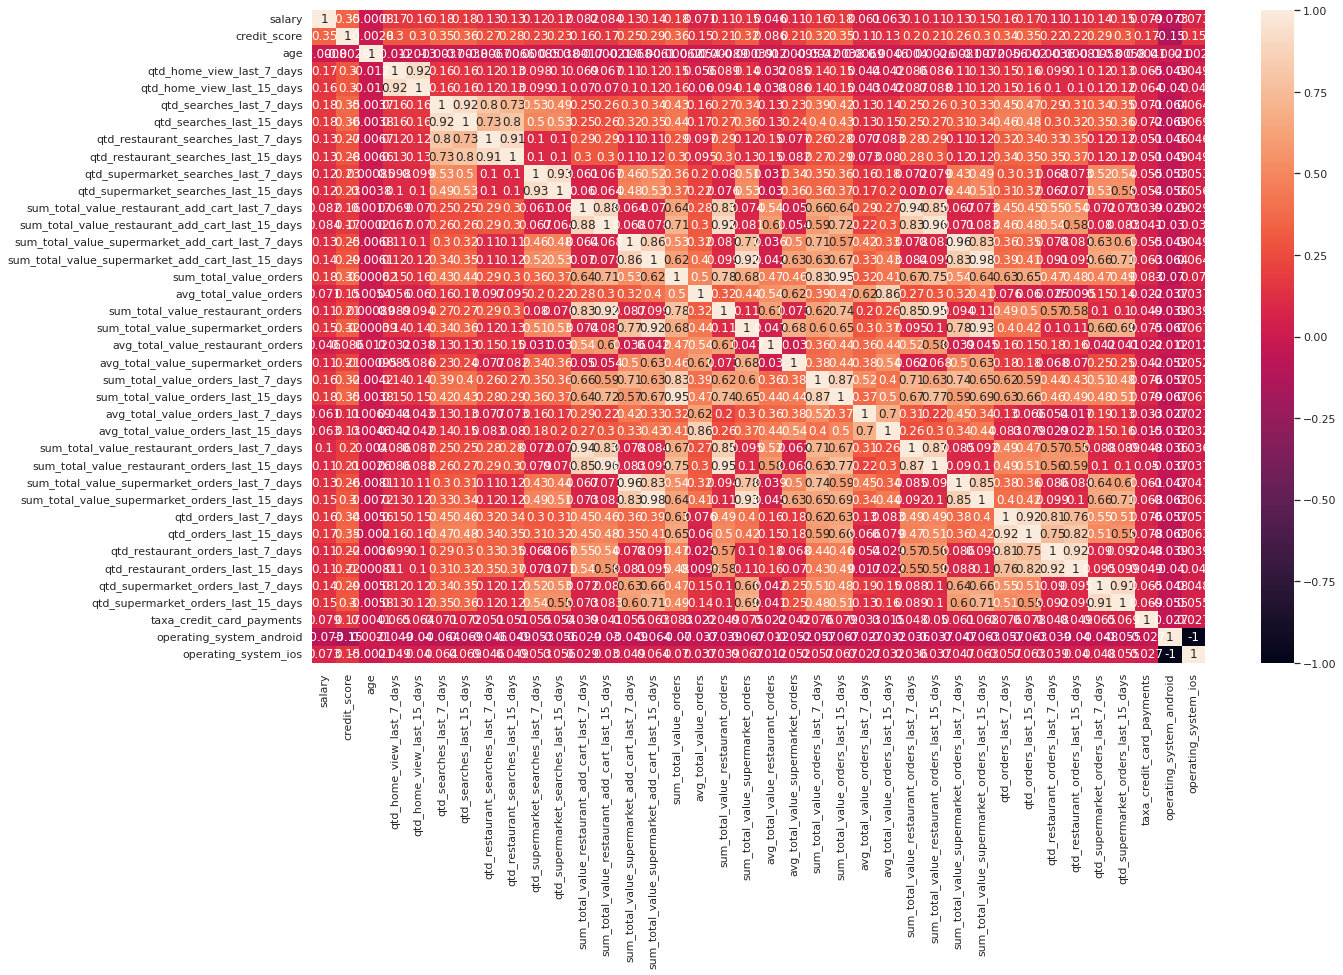

In [ ]:
sns.set(rc={'figure.figsize':(20,12)})
sns.heatmap(df_clean.drop(['user_id', 'target' ], axis=1).corr(), annot=True);

Plotando o set de variável sem as correlações

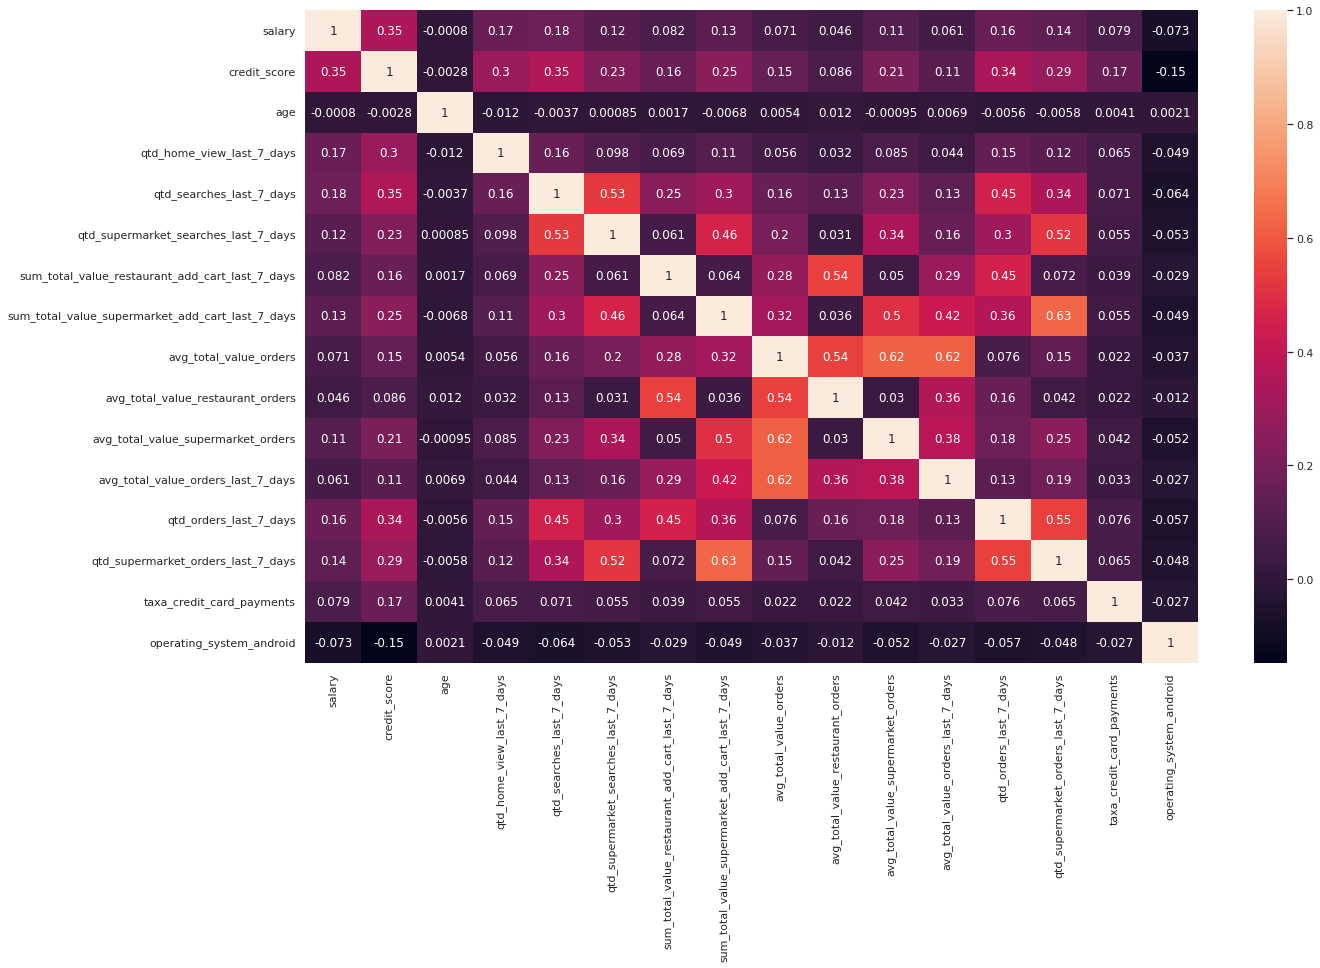

In [ ]:
sns.set(rc={'figure.figsize':(20,12)})
sns.heatmap(df_clean_2.drop(['user_id', 'target' ], axis=1).corr(), annot=True);

# Visualização dos dados

In [ ]:
df_clean_2.head()

,user_id,salary,credit_score,age,qtd_home_view_last_7_days,qtd_searches_last_7_days,qtd_supermarket_searches_last_7_days,sum_total_value_restaurant_add_cart_last_7_days,sum_total_value_supermarket_add_cart_last_7_days,avg_total_value_orders,avg_total_value_restaurant_orders,avg_total_value_supermarket_orders,avg_total_value_orders_last_7_days,qtd_orders_last_7_days,qtd_supermarket_orders_last_7_days,taxa_credit_card_payments,target,operating_system_android
0,8792,4682.76,781,47,4,8,1,84.01,11.00,55.653462,16.181515,56.800000,20.519423,15,2,0.769231,1,1
1,15536,2675.78,551,47,5,23,9,212.00,901.00,29.011489,22.950000,35.744762,16.020426,13,5,0.851064,1,0
2,16944,3278.60,814,47,6,19,8,619.99,1530.01,45.159836,31.566000,64.277500,28.841803,17,8,0.786885,1,0
3,19636,5209.68,606,47,0,12,0,986.00,0.00,158.367895,165.610556,28.000000,51.894737,9,0,0.736842,1,0
5,2572,226.20,655,47,0,11,1,1080.00,750.00,117.619048,71.000000,397.333333,80.714286,13,1,0.904762,1,0


## Salário

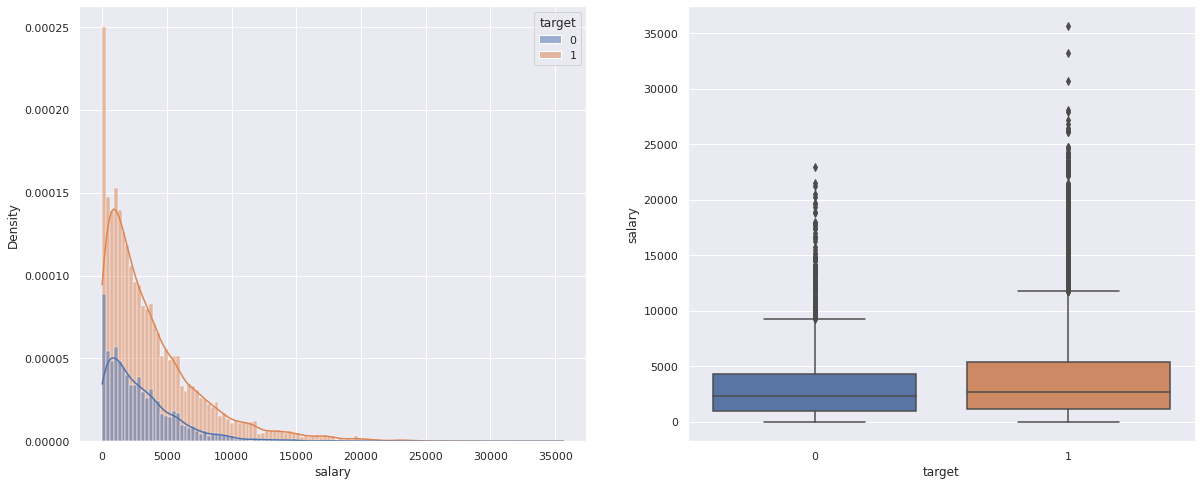

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="salary", hue="target", stat="density",  kde=True, ax=axs[0]) ;
sns.boxplot(data=df_clean_2, y="salary", x="target", ax=axs[1]);

Podemos ver que há uma diferença na distribuição dos salários entre pessoas que fizeram pedido na semana (target =1) e pessoas que não fizeram pedidos (target = 0). O final da calda da distribuição (target=1) é mais espesso, ou seja, possui mais pessoas com salários mais altos

## Score de crédito

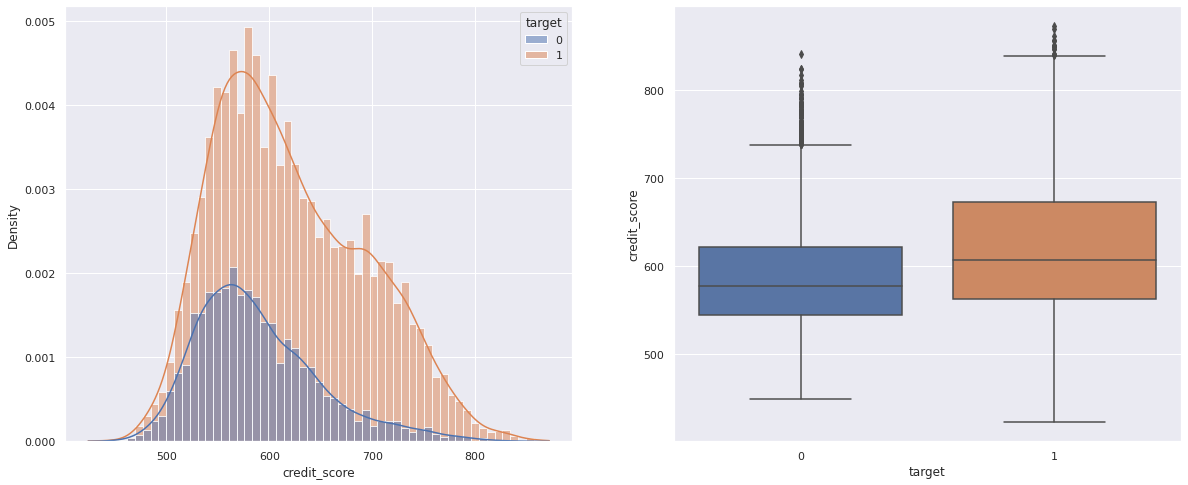

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="credit_score", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="credit_score", x="target", ax=axs[1]);

Mesma coisa aqui para o Score de crédito, usuários target = 1, possuem uma distribuição mais espessa em scores mais altos

## Idade do usuário

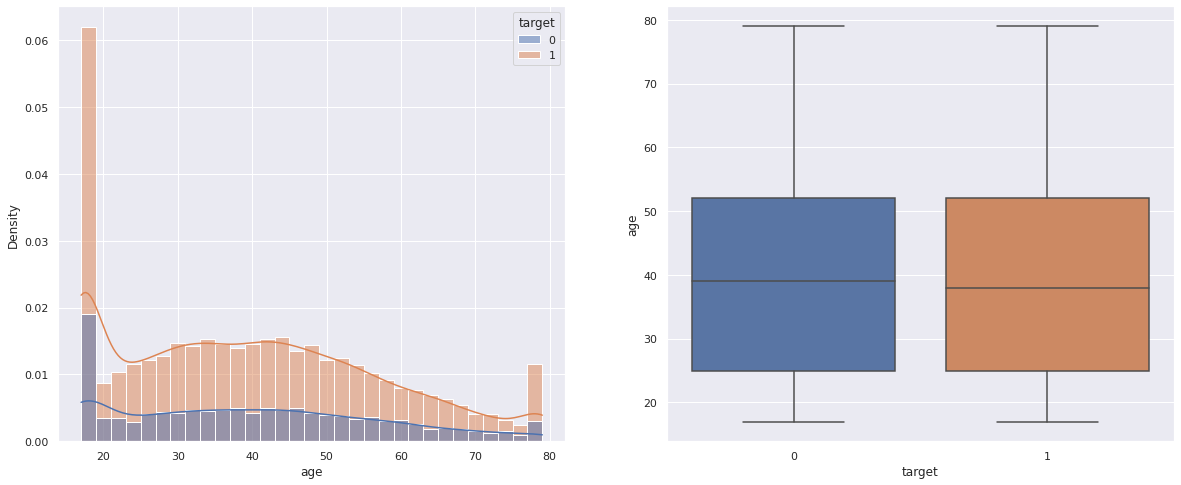

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="age", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="age", x="target", ax=axs[1]);

Quando falmos de idade, não parece influenciar muito o fato de realizar pedidos ou não

## Quantidade de visualizações de home page nos últimos 7 dias

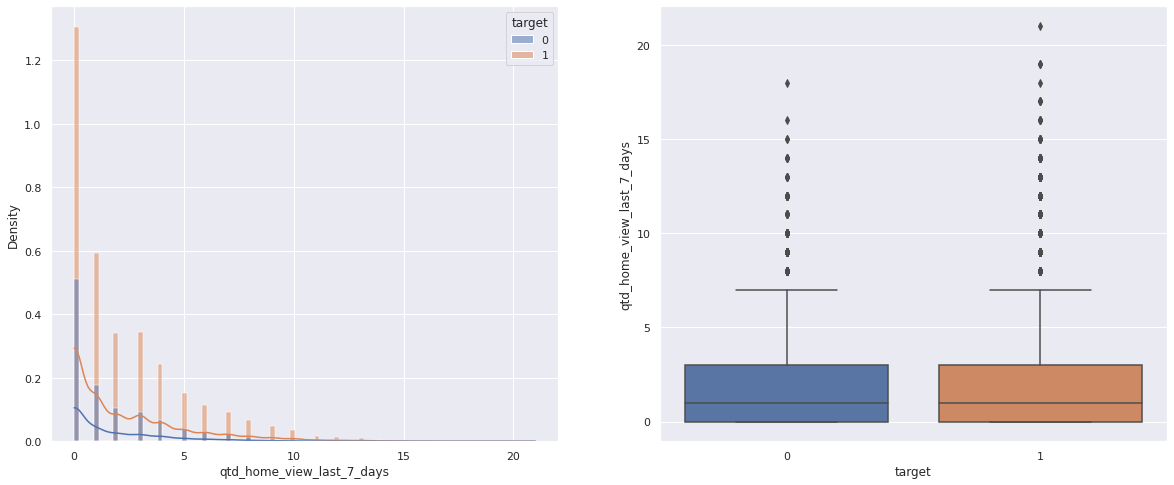

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="qtd_home_view_last_7_days", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="qtd_home_view_last_7_days", x="target", ax=axs[1]);

A quantidade de visualizações não parece ser uma variável que nos diz muita informação sobre a intenção de um usuário realizar um pedido ou não....as distribuição são muito parecidas

## Quantidade de buscas feitas nos últimos 7 dias

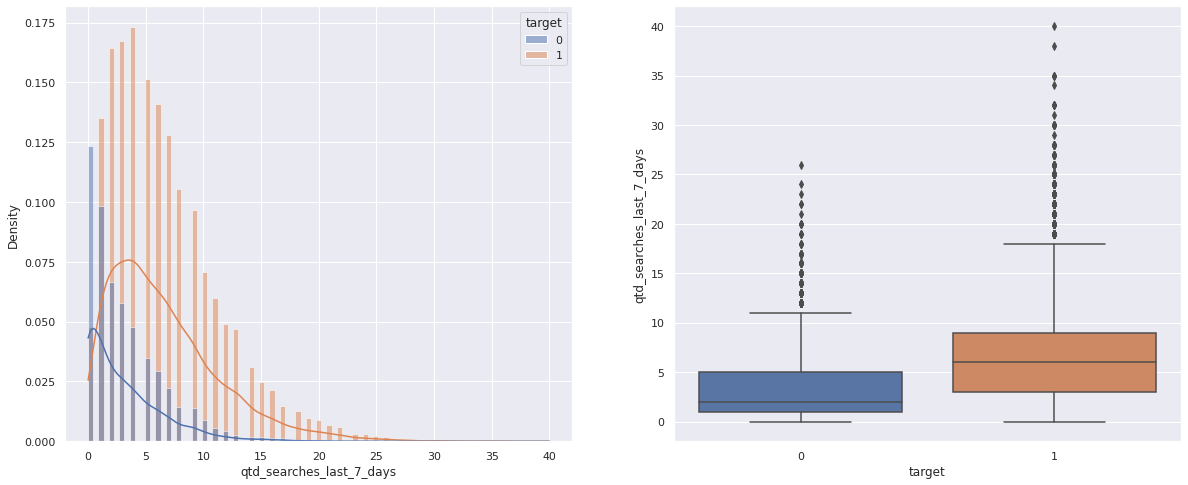

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="qtd_searches_last_7_days", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="qtd_searches_last_7_days", x="target", ax=axs[1]);

Vemos uma clara diferença aqui, usuários que fazem mais pedidos, buscam mais, visão muito clara pelo boxplot

## Quantidade de buscas feitas em supermercados nos últimos 7 dias

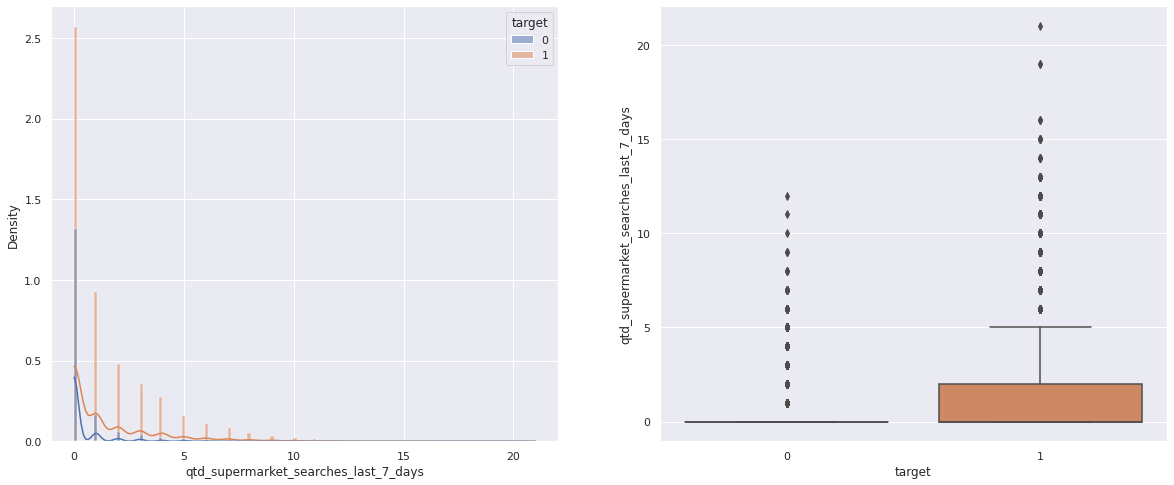

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="qtd_supermarket_searches_last_7_days", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="qtd_supermarket_searches_last_7_days", x="target", ax=axs[1]);

Usuários que fizeram pedidos, também buscas mais em supermercados

## Soma do valor total adicionado ao carrinho em restaurantes nos últimos 7 dias

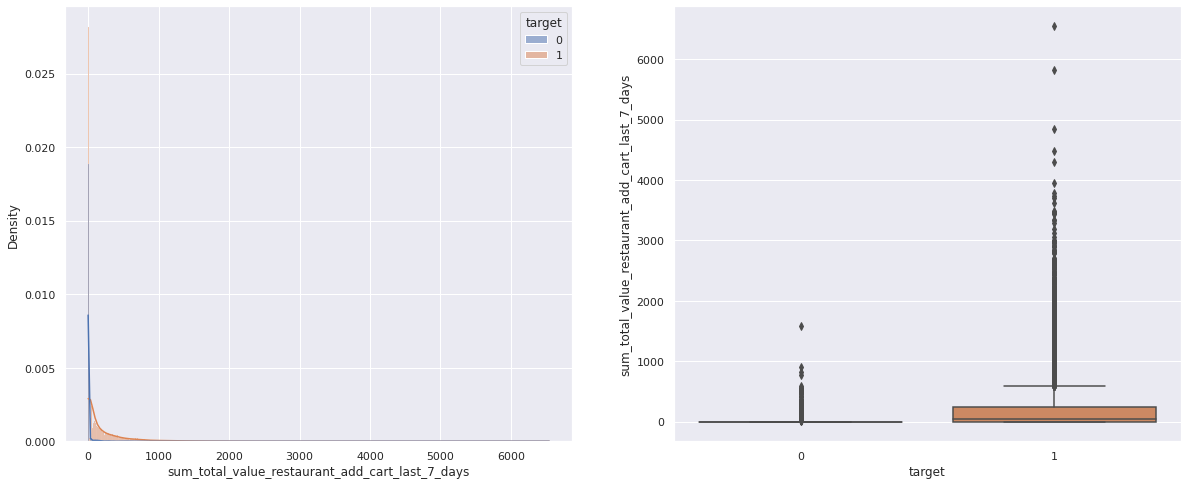

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="sum_total_value_restaurant_add_cart_last_7_days", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="sum_total_value_restaurant_add_cart_last_7_days", x="target", ax=axs[1]);

Existe uma diferença entre o valor de coisas adicionadas no carrinho por usuários que fizeram pedidos, eles adicionam coisas com maior valor

## Soma do valor total adicionado ao carrinho em supermercados nos últimos 7 dias

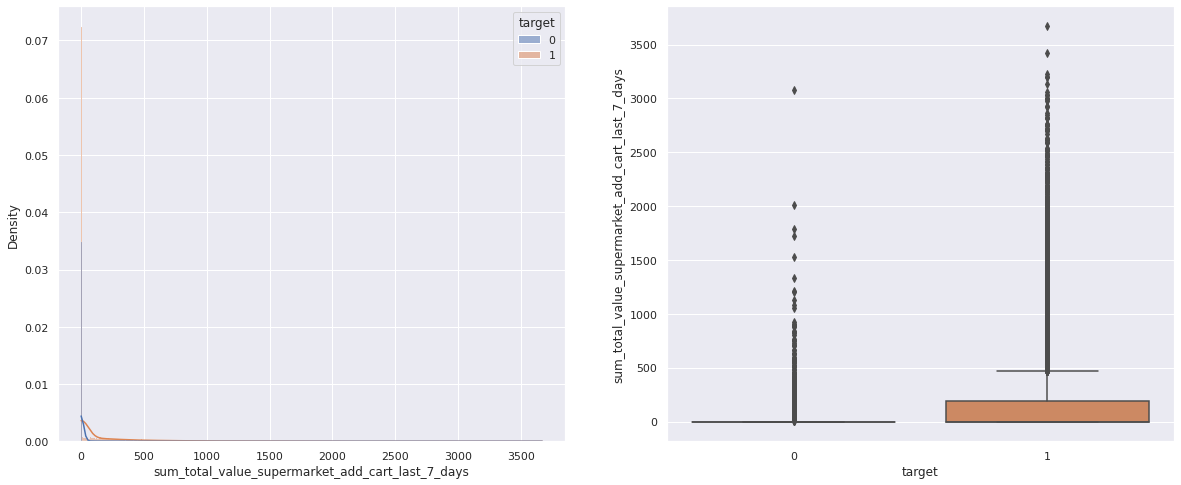

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="sum_total_value_supermarket_add_cart_last_7_days", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="sum_total_value_supermarket_add_cart_last_7_days", x="target", ax=axs[1]);

Existe uma diferença entre o valor de coisas adicionadas no carrinho em supermercados por usuários que fizeram pedidos, eles adicionam coisas com maior valor

## Média do valor total gasto em pedidos

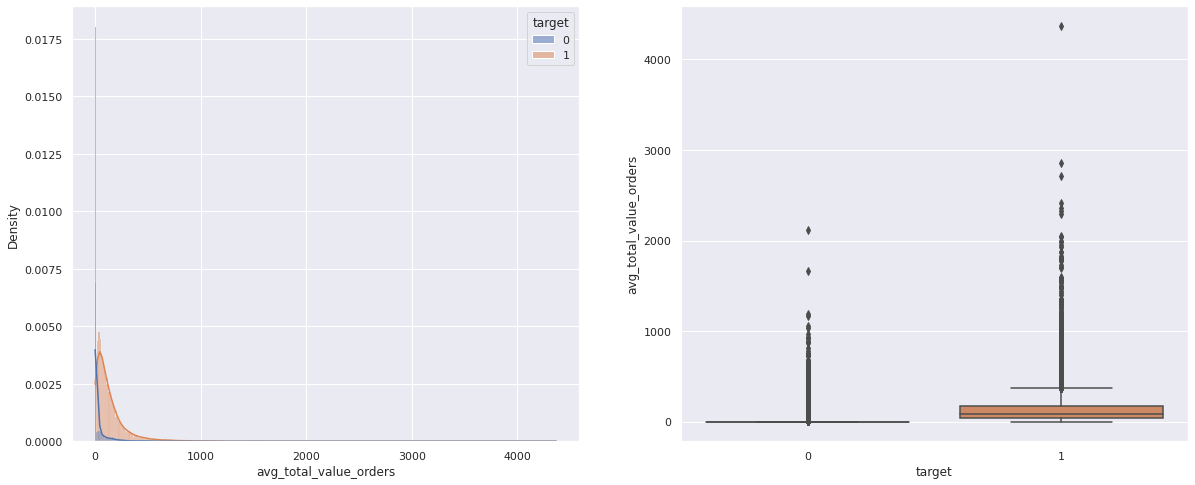

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="avg_total_value_orders", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="avg_total_value_orders", x="target", ax=axs[1]);

Usuários que gastaram mais no passado possuem uma chance maior de realizar um novo pedido dentro de uma determinada semana

## Média do valor total gasto em pedidos em restaurantes

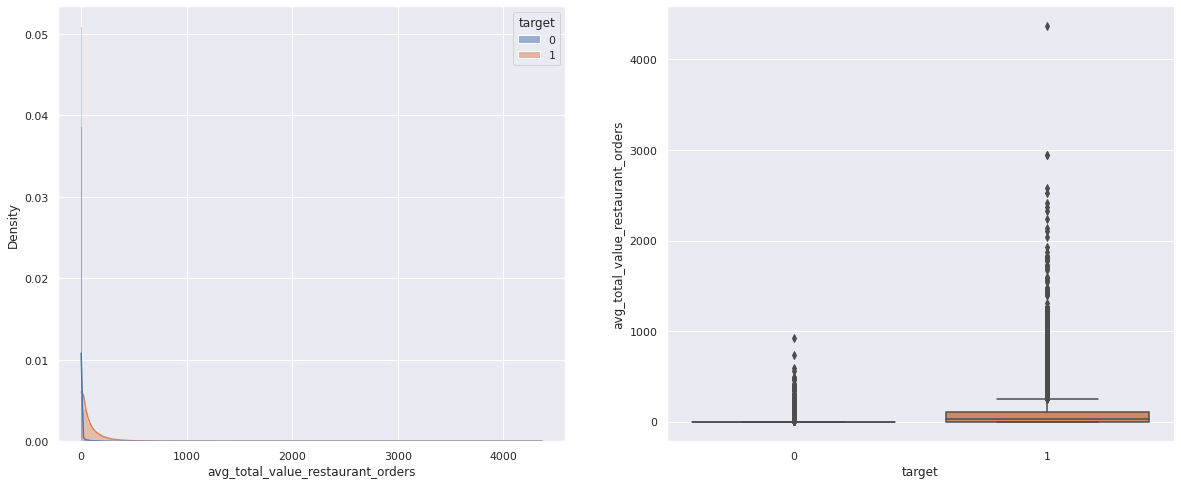

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="avg_total_value_restaurant_orders", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="avg_total_value_restaurant_orders", x="target", ax=axs[1]);

Usuários que gastaram mais no passado e restaurantes possuem uma chance maior de realizar um novo pedido dentro de uma determinada semana

## Taxa de pagamentos utilizando cartão de crédito

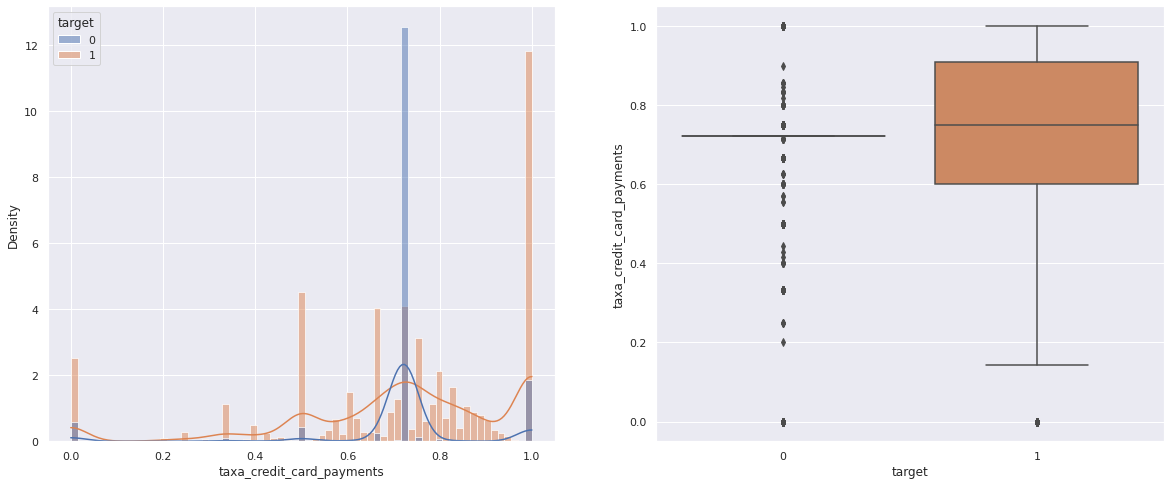

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="taxa_credit_card_payments", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="taxa_credit_card_payments", x="target", ax=axs[1]);

Usuários que pagam mais com cartão de crédito possuem mais chance de realizar um novo pedido

## Pairplot

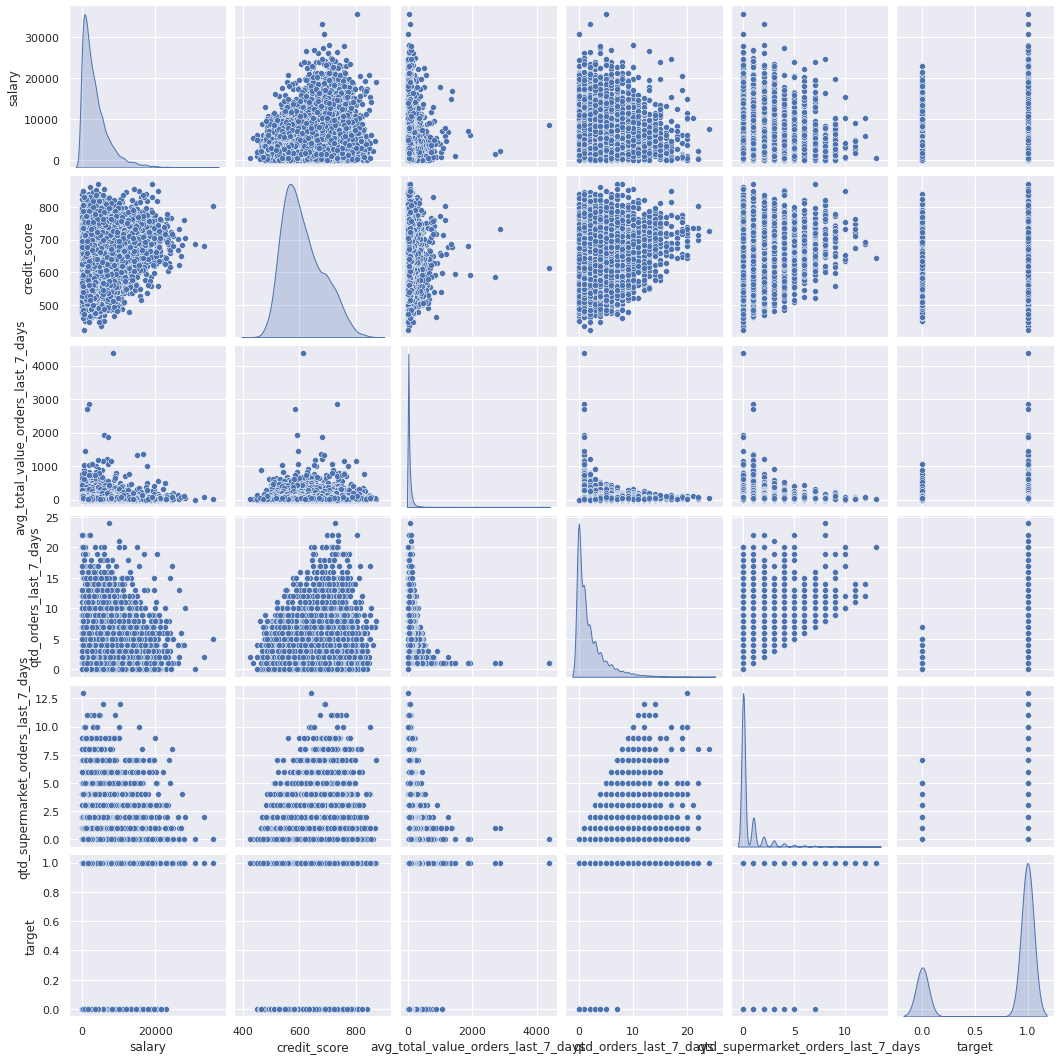

In [ ]:
VALS = ['salary', 'credit_score',
       'avg_total_value_orders_last_7_days', 'qtd_orders_last_7_days',
       'qtd_supermarket_orders_last_7_days', 
       'target']
sns.pairplot(df_clean_2[VALS], diag_kind="kde")

# Machine Learning

## Escolhendo os modelos

Modelos escolhidos:

* **Logistic Regression**: A regressão logistica parte da premissa que é possível separar o conjunto de dados de forma linear, ou seja, é possível com uma única reta/plano separar as duas classes de interesse (Y=0 e Y=1). O modelo basicamente é uma equação simples que pondera cada variável por um coeficiente e possui uma função logistica no final, para transformar a saída para o intervalo (0,1). Esses coeficientes, chamados betas da regressão, são calculados durante o treino do modelo.

* **Random Forest**: Esse modelo tem como unidade básica mais simples uma árvore de decisões. Ele utiliza a técnica de Bagging, onde N árvores são treinadas em paralelo com um conjuntos de variáveis que podem ser diferentes (escolhidas aleatoriamente). O resultado final é a média da saída dos modelos intermediários.

* **XGBoost**: Esse modelo também tem como unidade mais básica uma árvore de decisões. Porém utiliza a técnica de Boosting, onde as árvores são conectadas em série, ou seja, uma árvore é treinada, em seguida os pontos classificados erroneamente pela primeira árvore são trabalhados na árvore seguinte, e assim por diante. Cada árvore tenta resolver um pedaço do problema, dessa forma problemas complexos e não lineares, podem ser resolvidas em partes, o que resulta em um modelo muito versátil e amplamente utilizado.

## Treinando os modelos

In [ ]:
X = df_clean_2.drop(['user_id', 'target'], axis=1)
y = df_clean_2['target']
y = y.astype('int')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Regressão Logistíca

In [ ]:
lr = LogisticRegression(random_state = 42)


In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_scl = scaler.fit_transform(X_train)

In [ ]:
lr.fit(X_train_scl, y_train)

LogisticRegression(random_state=42)

### Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### XGBoost

In [ ]:
xgb = XGBClassifier(random_state=42)

In [ ]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

## Avaliando os modelos

### Regressão Logistíca

In [ ]:
y_pred_proba = lr.predict_proba(scaler.transform(X_test))[:,1]
y_pred_bin = lr.predict(scaler.transform(X_test))


AUC: 0.92
Test KS: KstestResult(statistic=0.6939861804476477, pvalue=1.62e-321, statistic_location=0.665113321996806, statistic_sign=-1)

ROC Curve:


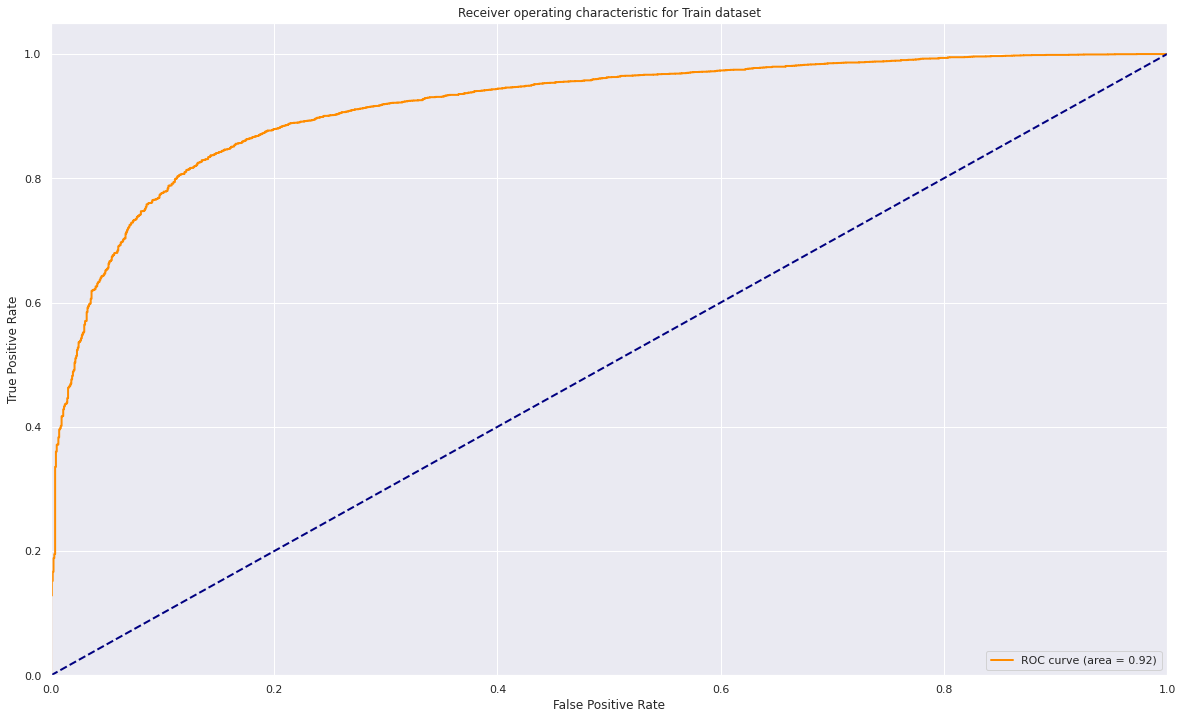

 Confusion Matrix: 


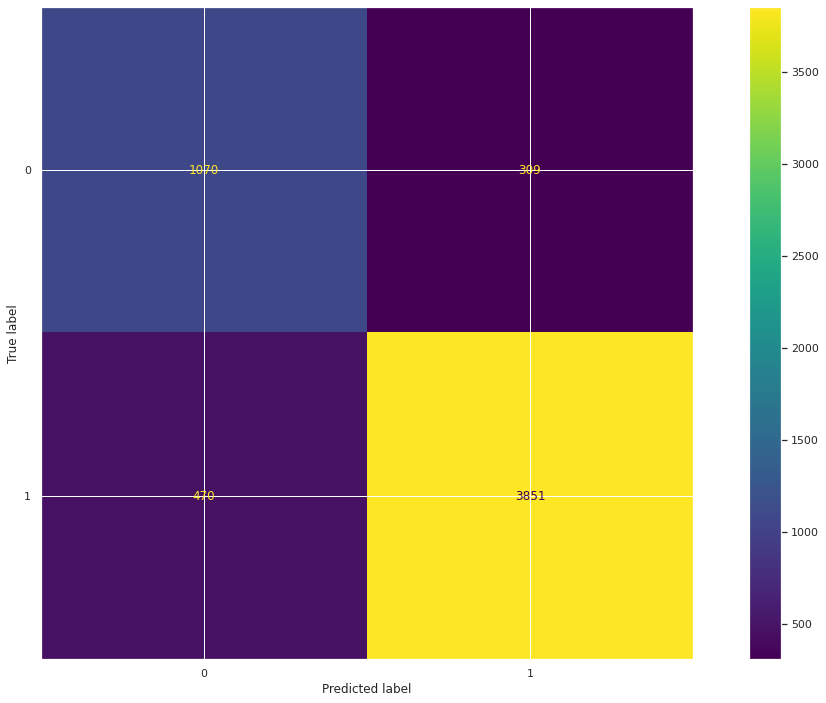


------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.78      0.73      1379
           1       0.93      0.89      0.91      4321

    accuracy                           0.86      5700
   macro avg       0.81      0.83      0.82      5700
weighted avg       0.87      0.86      0.87      5700

------------------------------------
Probability Distribution:


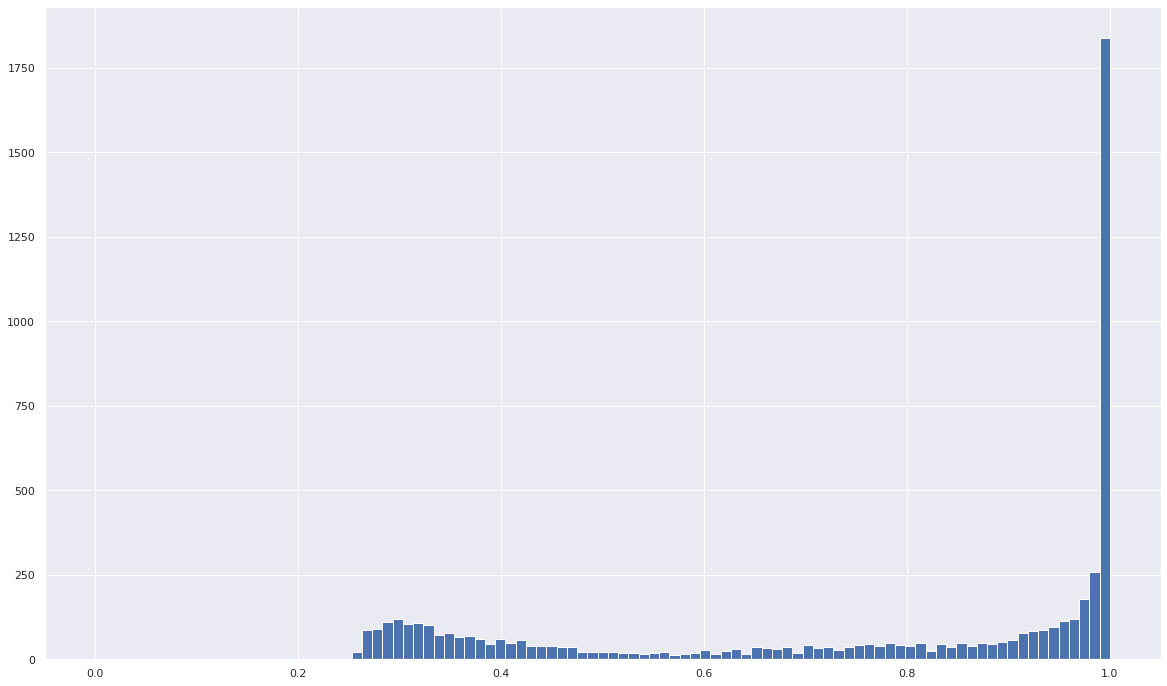

Probability Distribution between the classes:


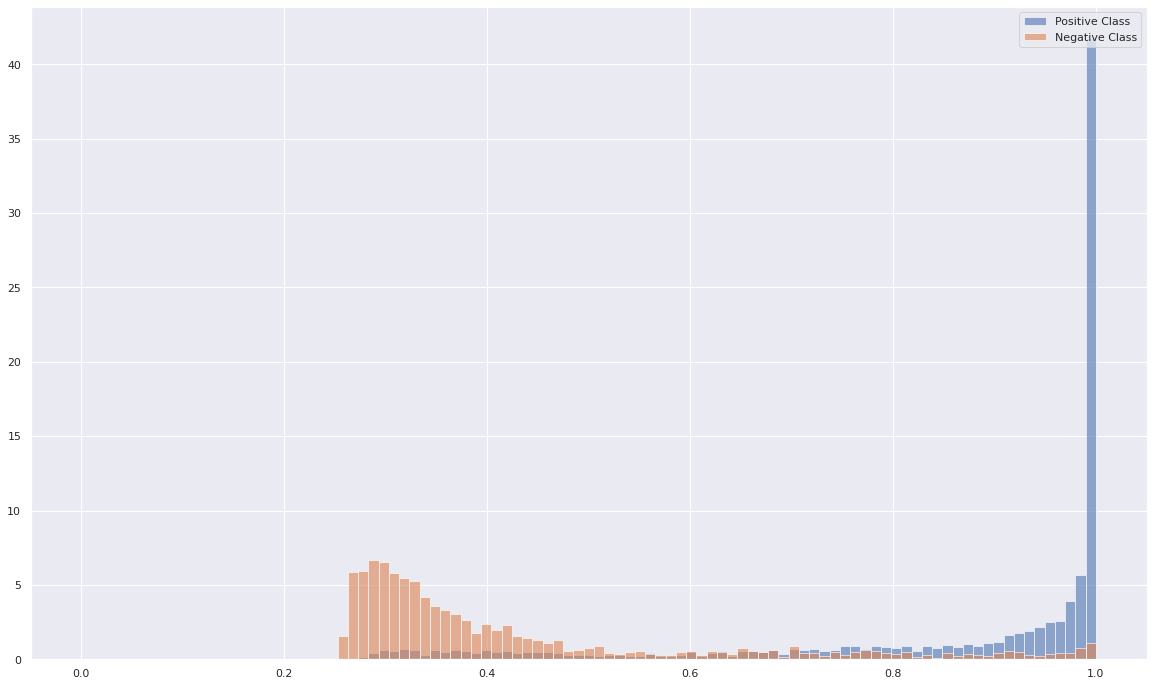

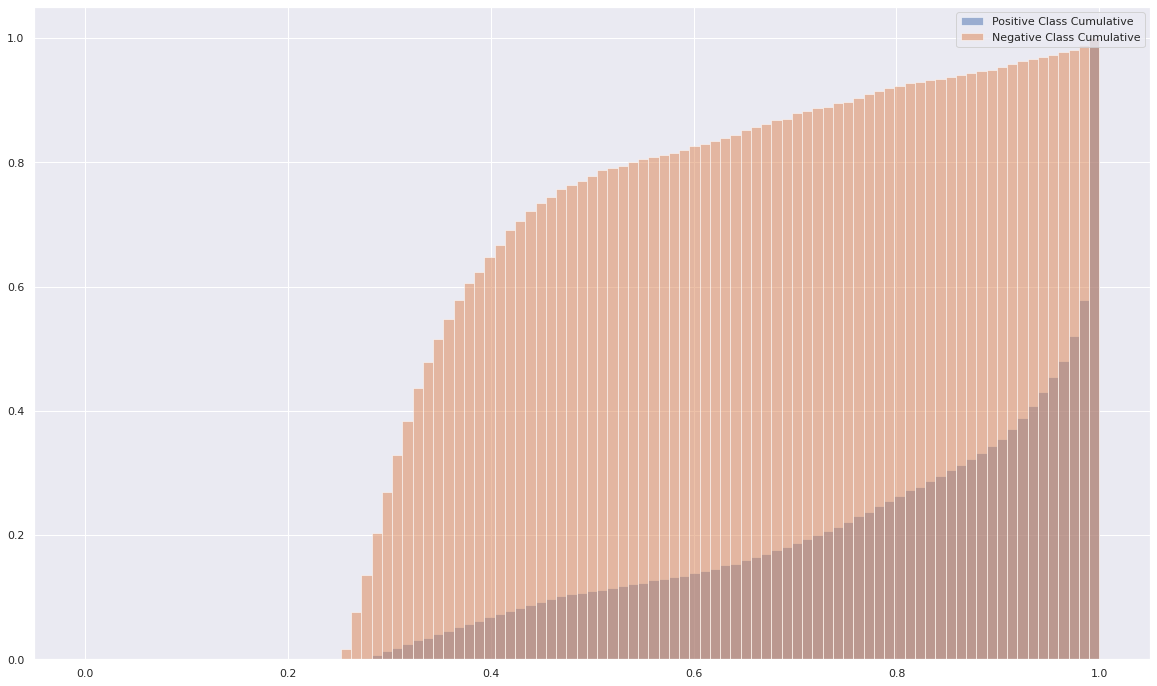

In [ ]:
calcula_metricas(y_test, y_pred_proba, y_pred_bin)

### Random Forest

In [ ]:
y_pred_proba = rf.predict_proba(X_test)[:,1]
y_pred_bin = rf.predict(X_test)


AUC: 0.93
Test KS: KstestResult(statistic=0.7251665181712865, pvalue=1.344e-321, statistic_location=0.74, statistic_sign=-1)

ROC Curve:


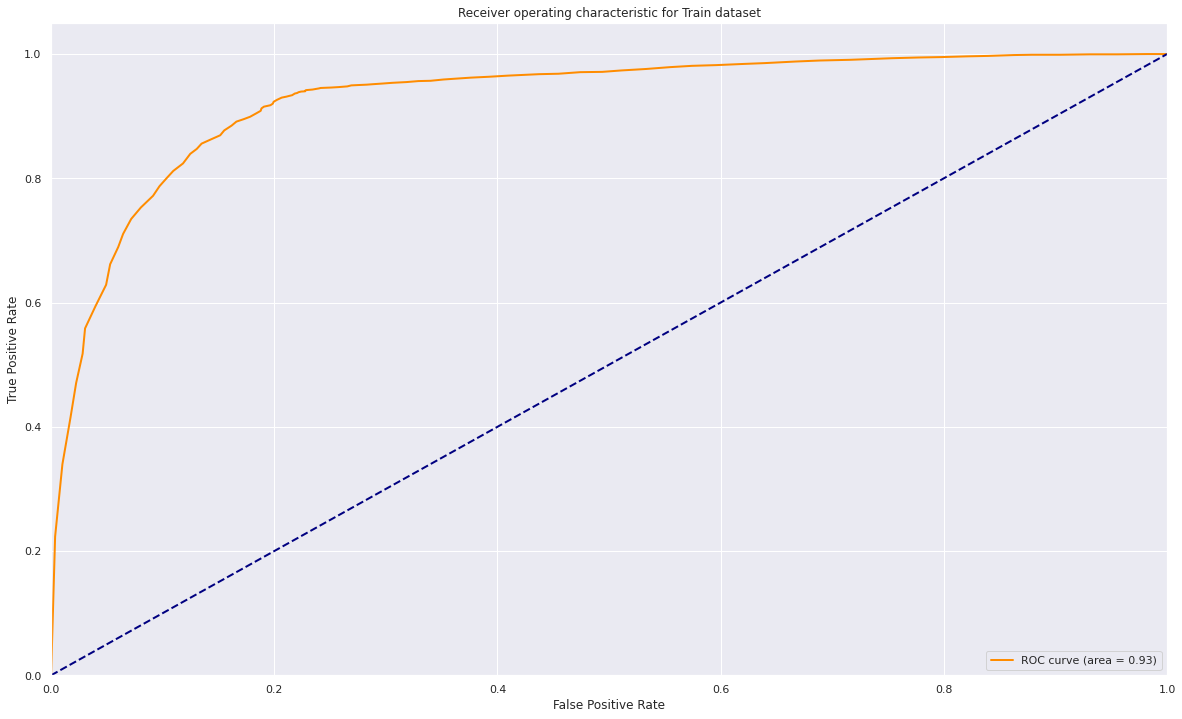

 Confusion Matrix: 


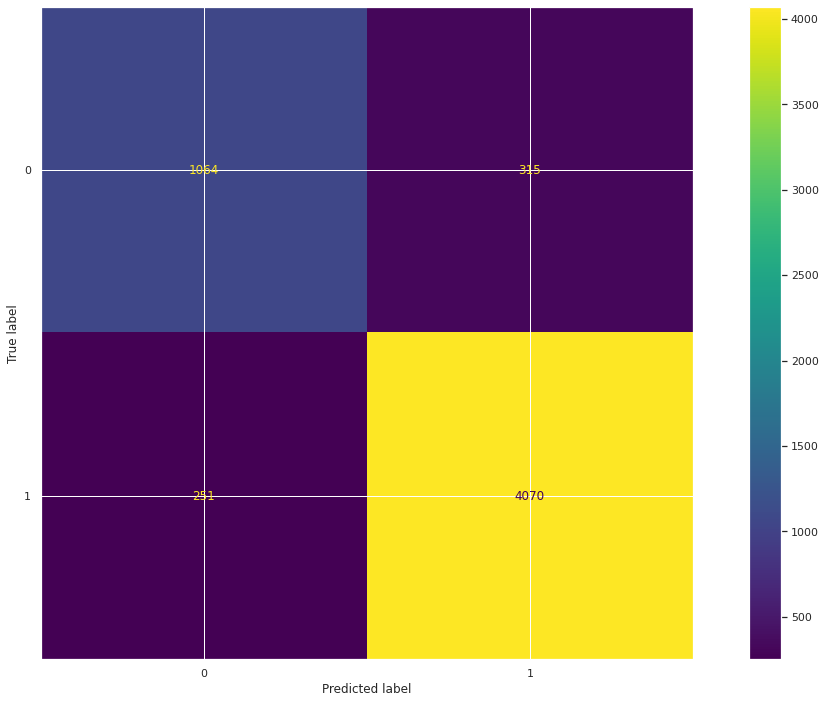


------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1379
           1       0.93      0.94      0.93      4321

    accuracy                           0.90      5700
   macro avg       0.87      0.86      0.86      5700
weighted avg       0.90      0.90      0.90      5700

------------------------------------
Probability Distribution:


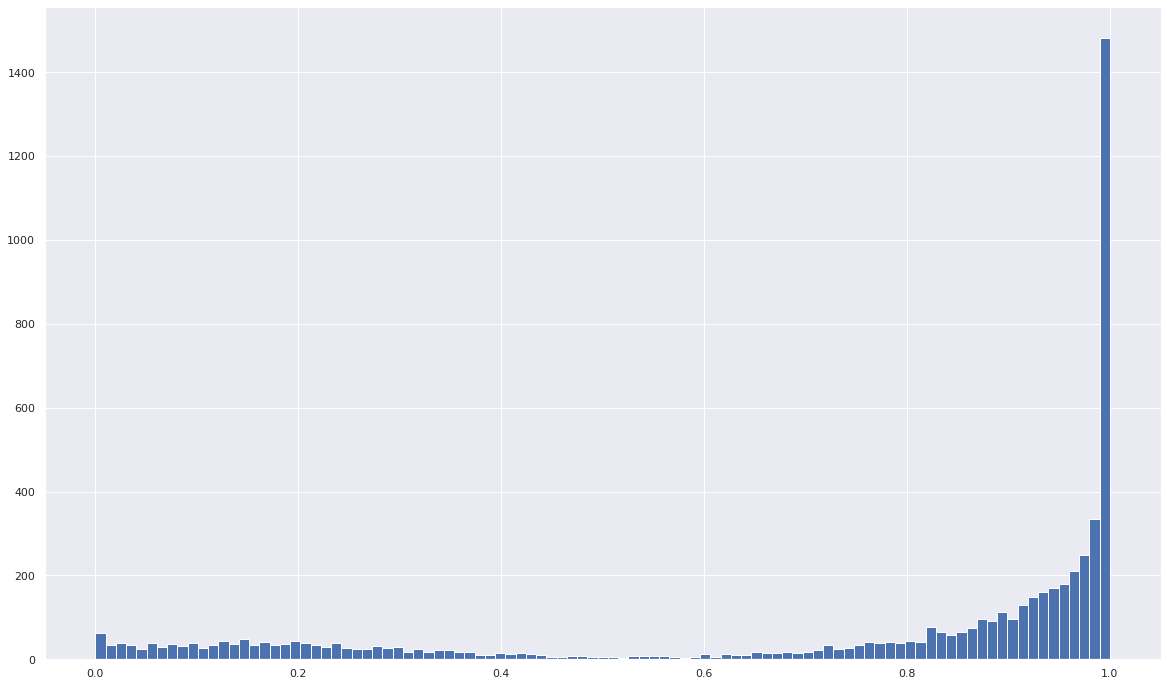

Probability Distribution between the classes:


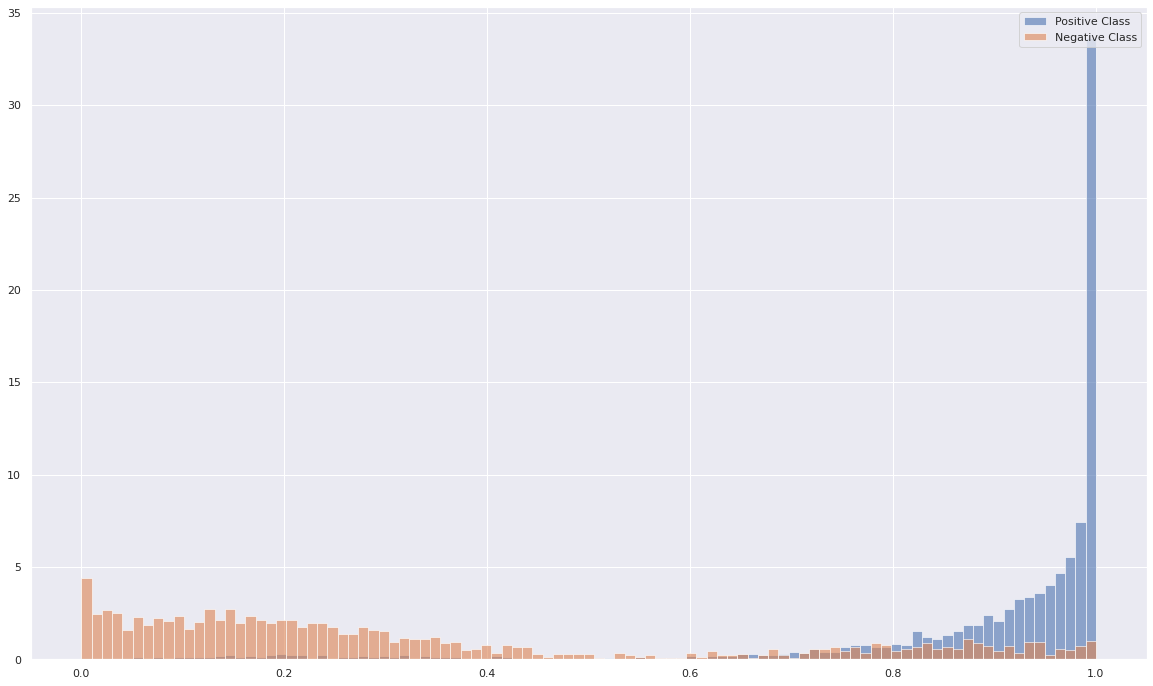

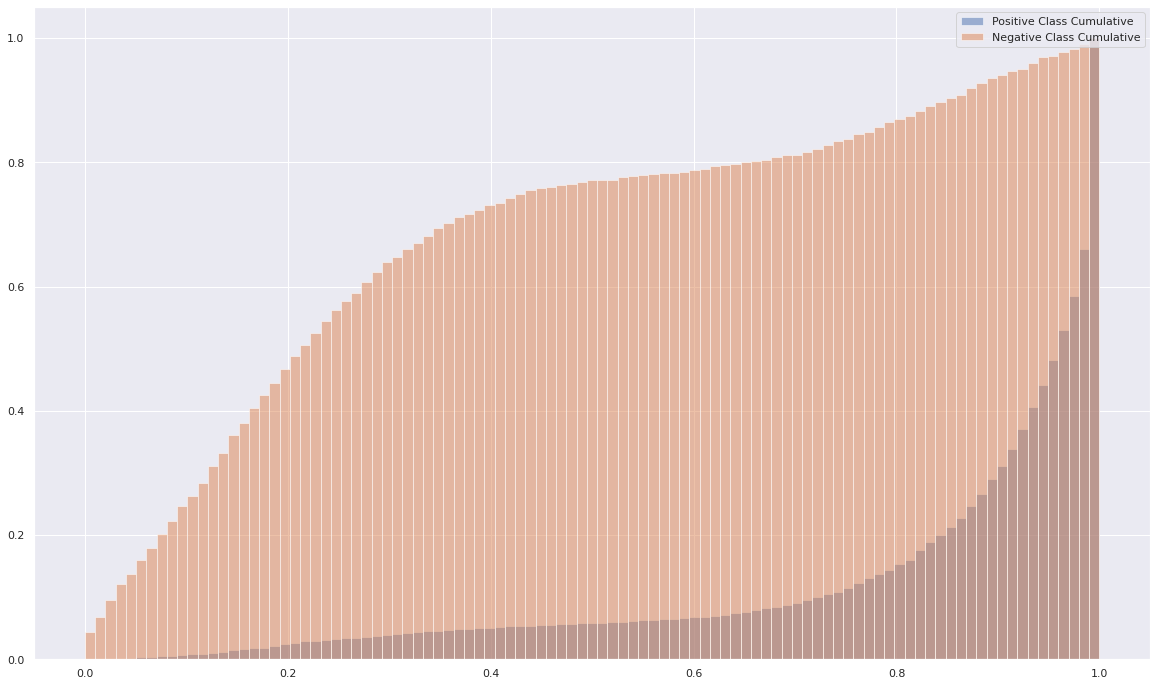

In [ ]:
calcula_metricas(y_test, y_pred_proba, y_pred_bin)

### XGBoost

In [ ]:
y_pred_proba = xgb.predict_proba(X_test)[:,1]
y_pred_bin = xgb.predict(X_test)


AUC: 0.93
Test KS: KstestResult(statistic=0.7282521117587027, pvalue=1.314e-321, statistic_location=0.7318498, statistic_sign=-1)

ROC Curve:


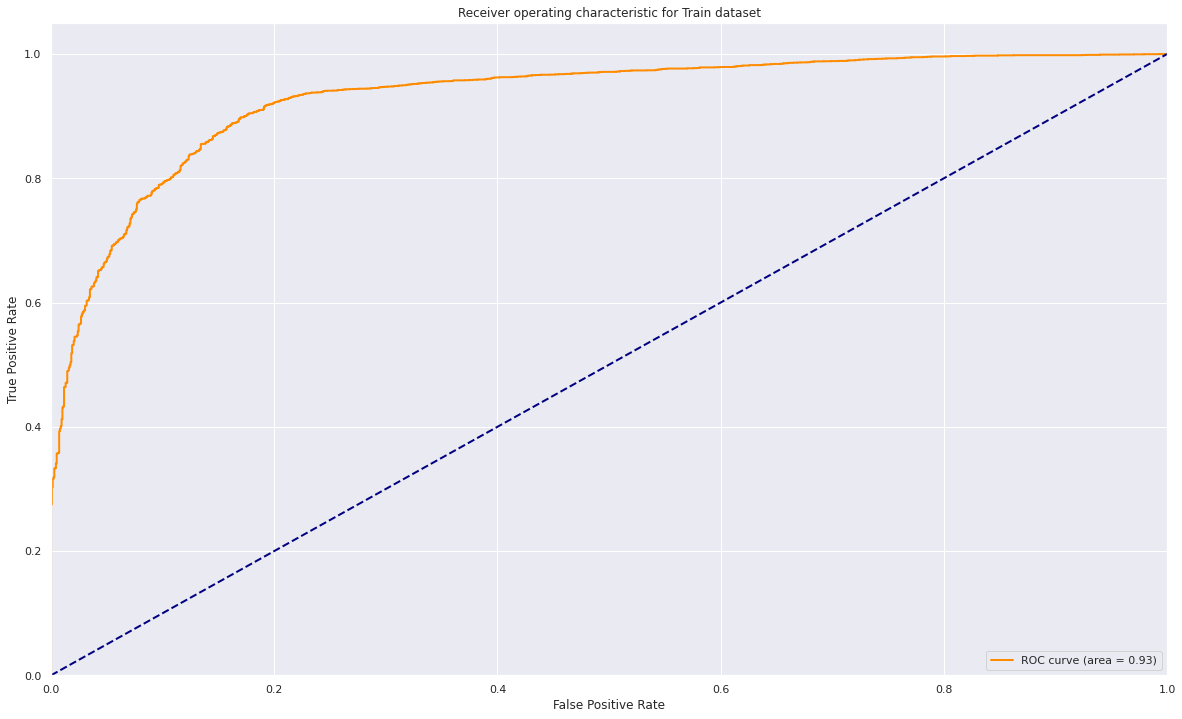

 Confusion Matrix: 


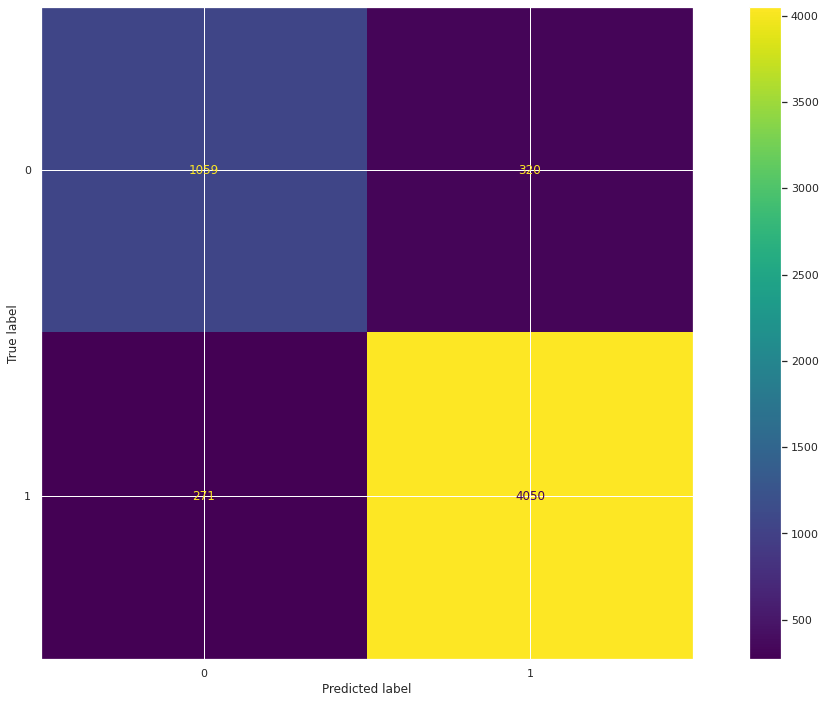


------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1379
           1       0.93      0.94      0.93      4321

    accuracy                           0.90      5700
   macro avg       0.86      0.85      0.86      5700
weighted avg       0.90      0.90      0.90      5700

------------------------------------
Probability Distribution:


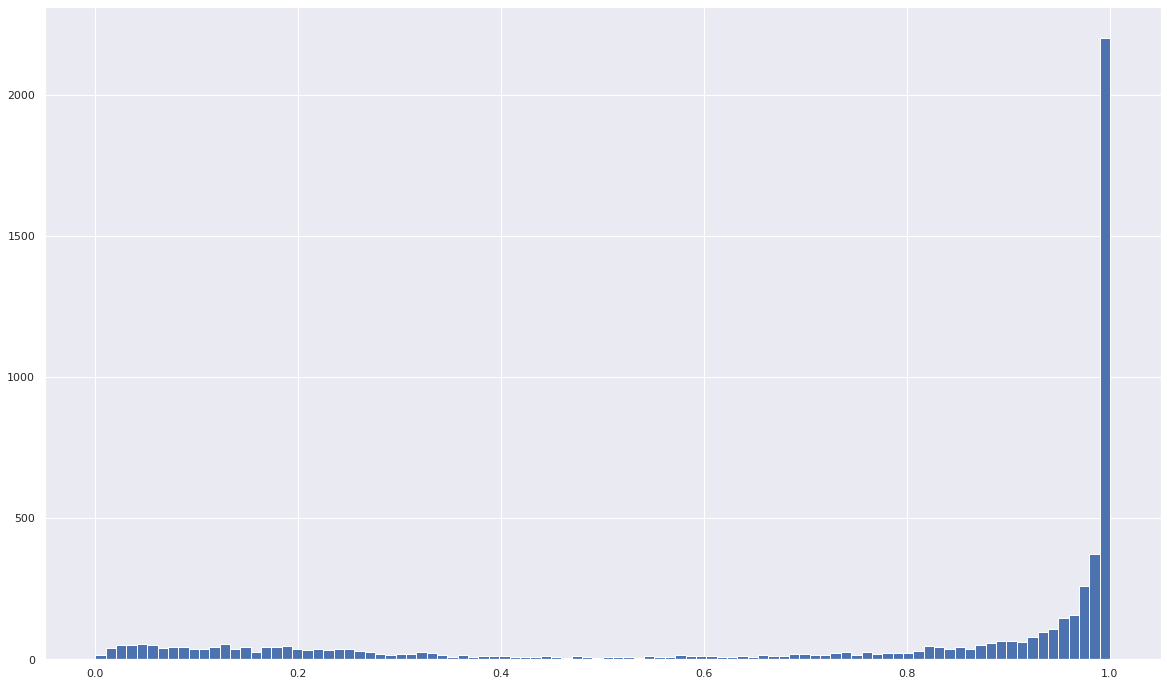

Probability Distribution between the classes:


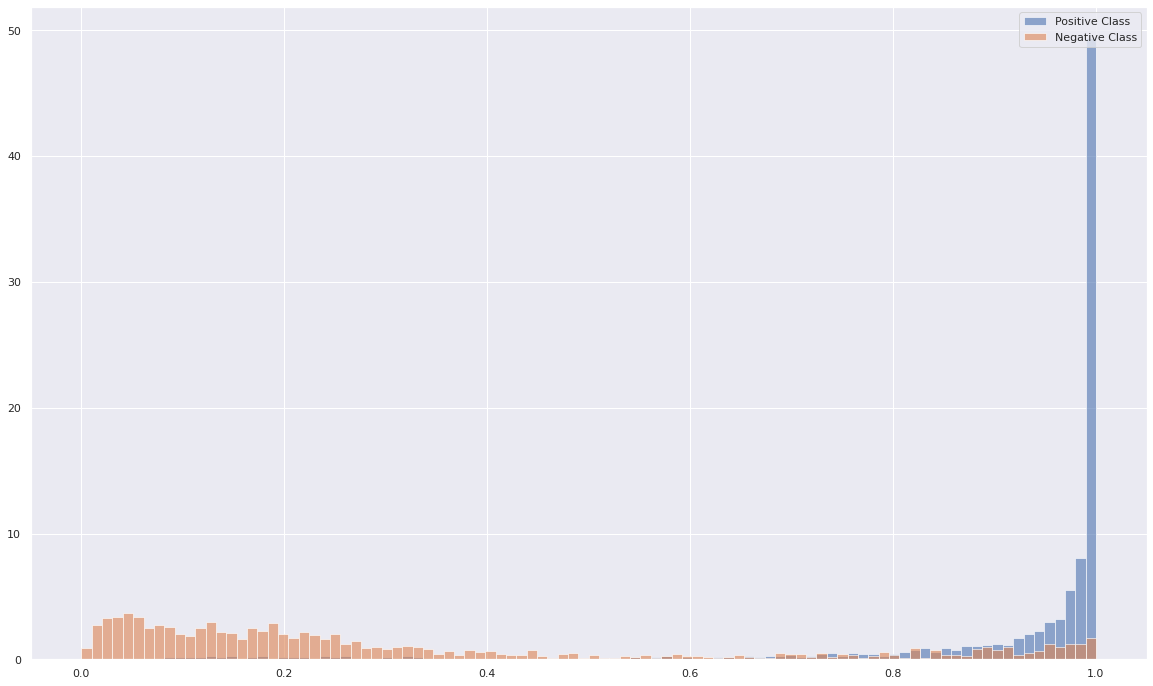

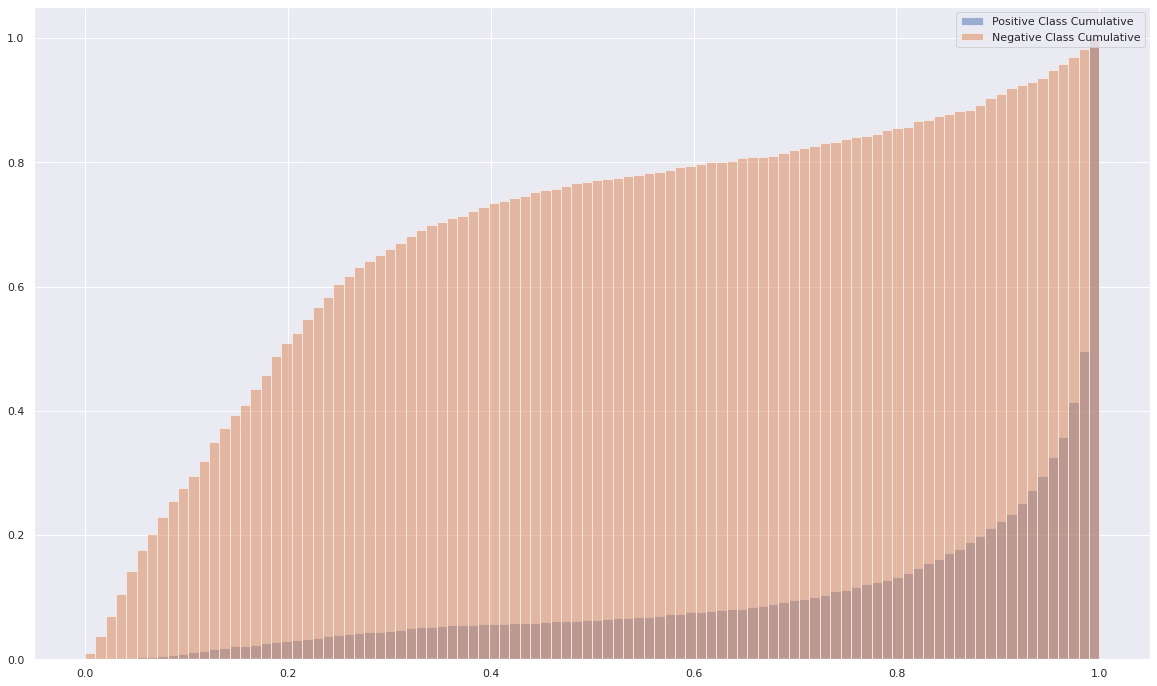

In [ ]:
calcula_metricas(y_test, y_pred_proba, y_pred_bin)

## Calibrando os hiperparâmetros do modelo

Analisando os resultados dos 3 modelos, chegamos a conclusão que o XGBoost apresentou um resultado melhor que os outros dois modelos. Assim, ele é escolhido para a etapa de calibração dos hiperparâmetros

In [ ]:
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.59),
              'subsample': stats.uniform(0.3, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.4),
              'min_child_weight': [1, 2, 3, 4]
             }
clf = RandomizedSearchCV(xgb, param_dist, random_state=42, n_iter=5, scoring='roc_auc', cv=3)
search = clf.fit(X_train, y_train)
search.best_params_

{'colsample_bytree': 0.7832290311184182,
 'learning_rate': 0.02214485163452344,
 'max_depth': 4,
 'min_child_weight': 4,
 'n_estimators': 641,
 'subsample': 0.8631316254094501}

In [ ]:
xgb_cal = XGBClassifier(random_state=42,
                        colsample_bytree= 0.7832290311184182,
                        learning_rate = 0.02214485163452344,
                        max_depth = 4,
                        min_child_weight = 4,
                        n_estimators = 641,
                        subsample = 0.8631316254094501
                        )

In [ ]:
xgb_cal.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7832290311184182, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02214485163452344,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=641, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
y_pred_proba = xgb_cal.predict_proba(X_test)[:,1]
y_pred_bin = xgb_cal.predict(X_test)


AUC: 0.94
Test KS: KstestResult(statistic=0.7312756108379419, pvalue=1.29e-321, statistic_location=0.70600456, statistic_sign=-1)

ROC Curve:


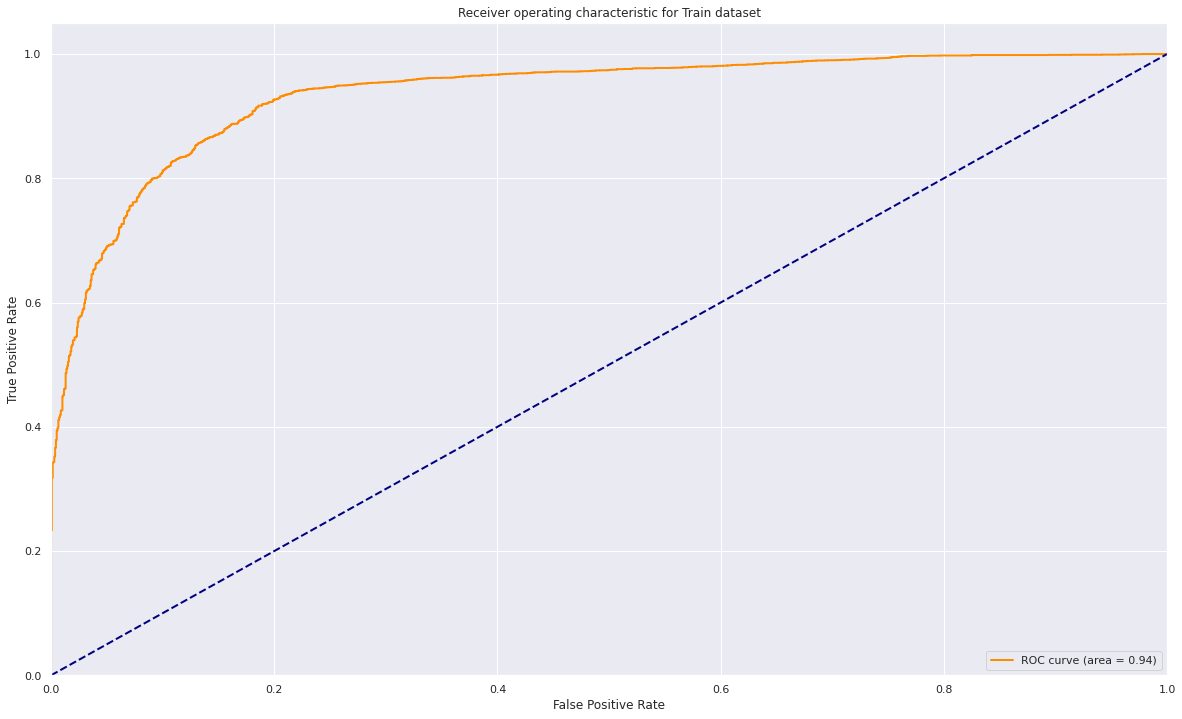

 Confusion Matrix: 


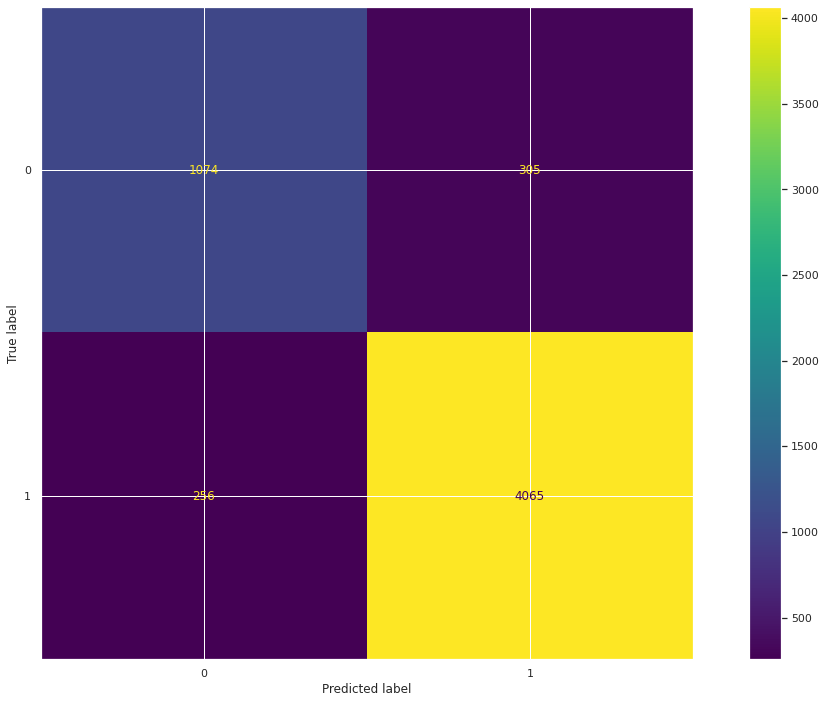


------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1379
           1       0.93      0.94      0.94      4321

    accuracy                           0.90      5700
   macro avg       0.87      0.86      0.86      5700
weighted avg       0.90      0.90      0.90      5700

------------------------------------
Probability Distribution:


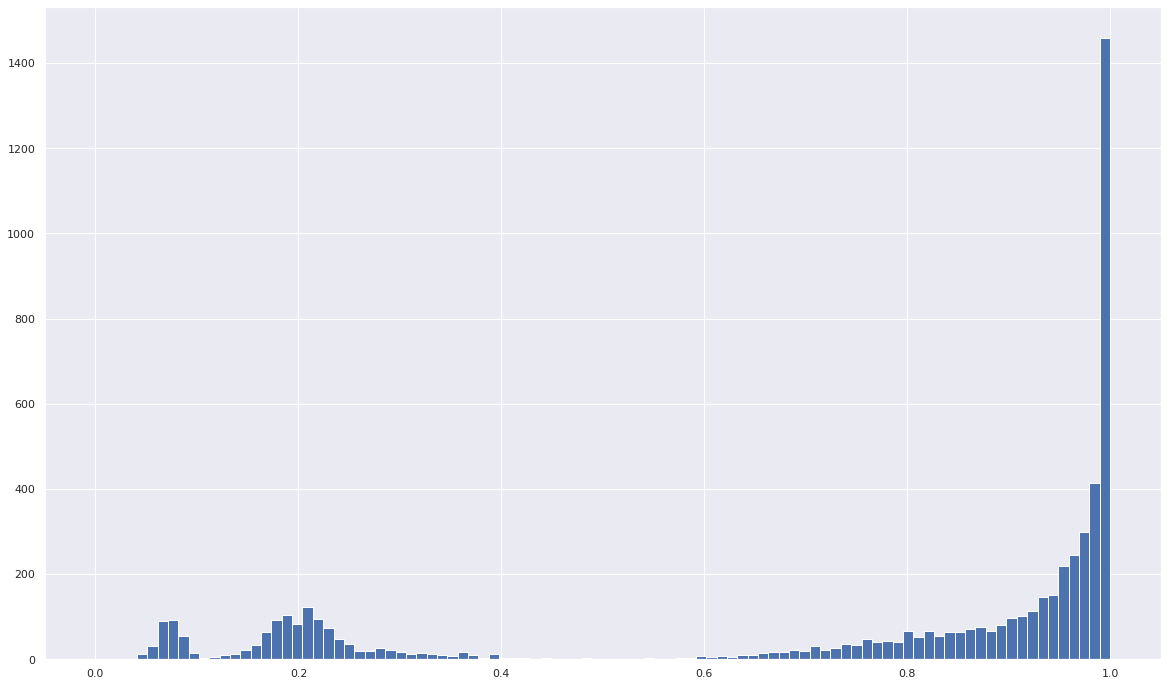

Probability Distribution between the classes:


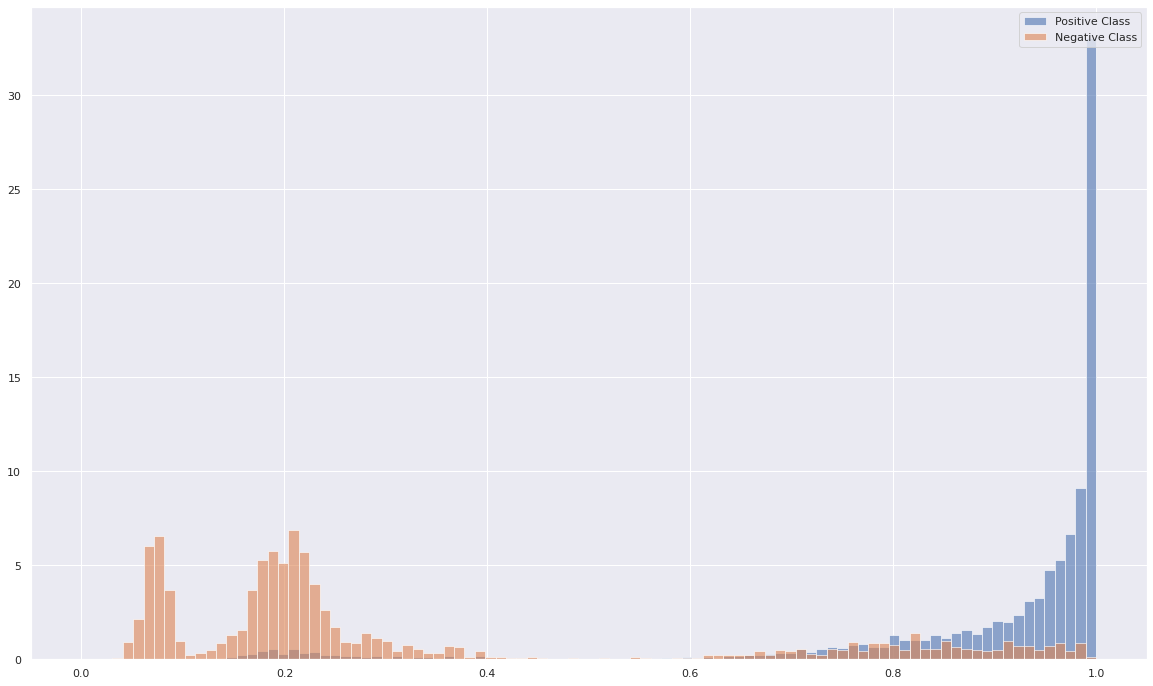

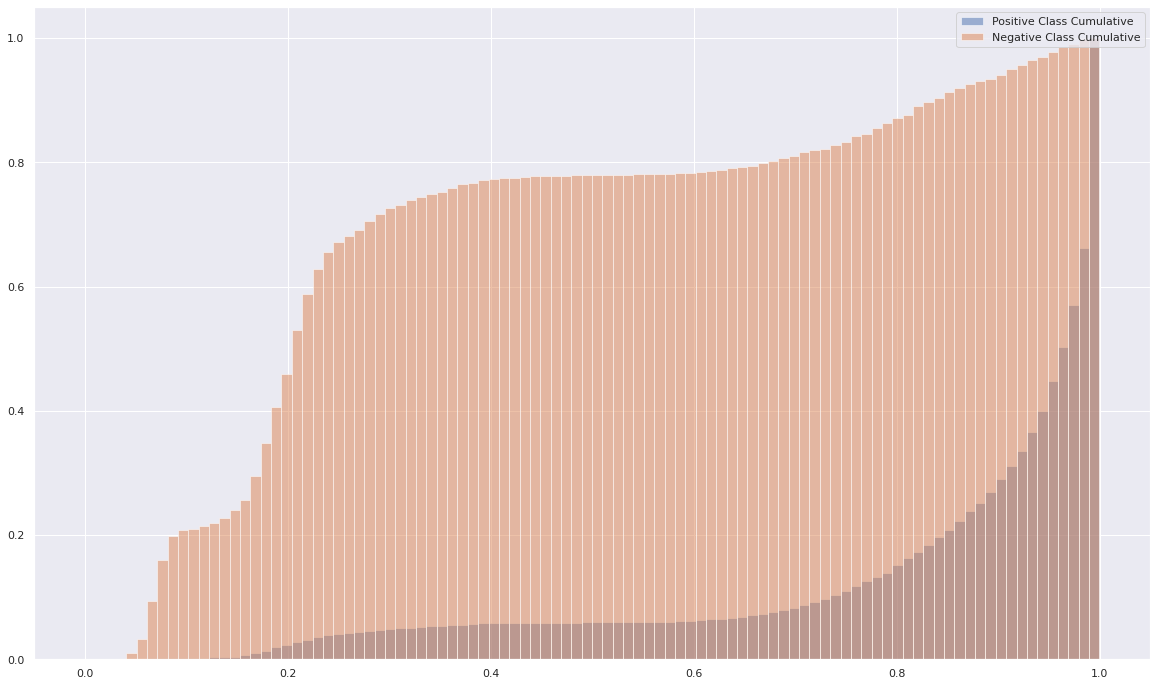

In [ ]:
calcula_metricas(y_test, y_pred_proba, y_pred_bin)

# Interpretabilidade dos modelos

## Coeficientes de uma regressão

In [ ]:
coefs = pd.DataFrame(
    lr.coef_[0],
    columns=['Coefficients'], index=X_train.columns.tolist()
)
df_coef = coefs.reindex(coefs['Coefficients'].abs().sort_values(ascending=False).index)

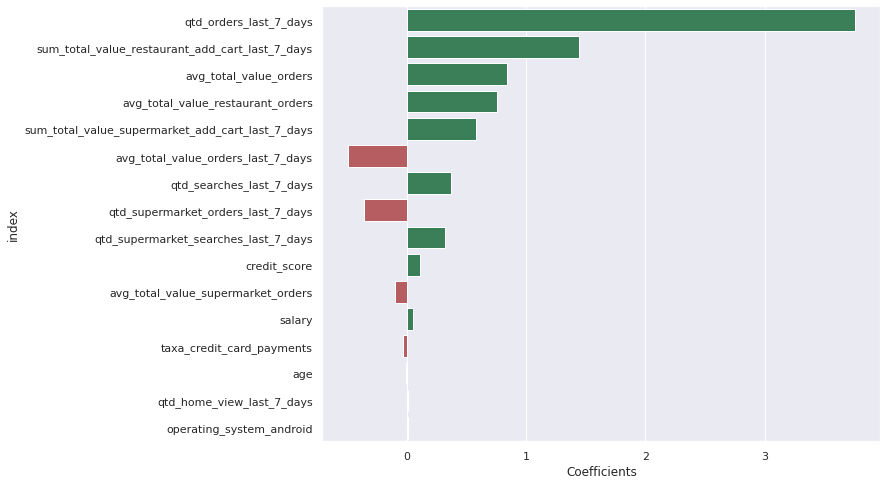

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x="Coefficients", y="index", data=df_coef.reset_index(),
            label="coefs", palette=["seagreen" if x>=0 else 'r' for x in df_coef["Coefficients"]])
plt.show()

## Shap

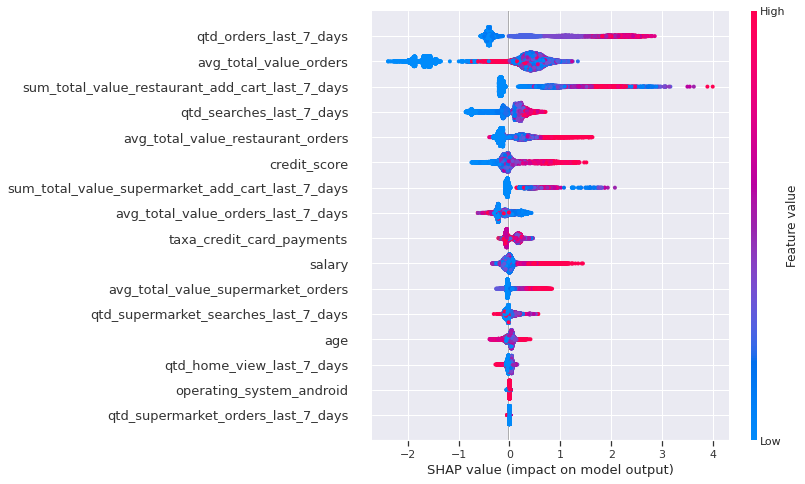

In [74]:
shap.initjs()
explainer = shap.Explainer(xgb_cal)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values, max_display=20);

## Comparando os dois resultados 

As duas visões convergem muito bem, vemos que as 3 principais variáveis (em ordem de importância de cima para baixo), são:

* **qtd_orders_last_7_days**
* **avg_total_value_orders**
* **sum_total_value_restaurant_add_cart_last_7_days** 

E ambas as visões nos dizem que valores altos dessas variáveis tendem a gerar uma predição Y=1, ou seja, um determinado usuário com essas características têm uma probabilidade maior de realizar algum novo pedido nessa semana